# CRM Analytics Project

## 1. Introduction
This project analyzes transactional data from a UK-based non-store online retailer. The dataset contains transactions recorded between **December 1, 2010**, and **December 9, 2011**, and is sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/352/online+retail). The primary objective of this analysis is to extract insights about customer behavior, identify trends, and establish actionable recommendations for customer relationship management (CRM).

### Objectives
1. **Data Exploration**: Understand the structure, completeness, and quality of the dataset.
2. **Data Cleaning**: Address missing values, duplicates, and inconsistencies.
3. **Feature Engineering**: Create new metrics to better analyze customer behavior.
4. **Statistical Analysis**: Explore correlations and distributions for key variables.
5. **Visualization**: Present findings using clear and compelling visual tools.
6. **Insights and Recommendations**: Provide actionable insights for CRM improvements.

### Dataset Summary
- **Source**: UCI Machine Learning Repository
- **Data Description**: Contains invoices, stock codes, product descriptions, quantities, prices, customer IDs, and invoice dates.
- **Time Period**: December 1, 2010, to December 9, 2011
- **Key Attributes**:
  - `InvoiceNo`: Unique transaction identifier
  - `StockCode`: Product code
  - `Description`: Product description
  - `Quantity`: Quantity purchased
  - `InvoiceDate`: Date of transaction
  - `UnitPrice`: Price per unit of product
  - `CustomerID`: Unique identifier for customers
  - `Country`: Country of purchase

Next, we proceed with the initial exploration of the dataset, starting with loading and inspecting the data.


## Table of Contents
1. [Introduction](#crm-analytics-project)
2. [Data Preparation & EDA](#2-data-preparation--eda)
3. [EDA](#3-eda)
   - [Order Basket & Total Sale](#32-order-basket--total-sale)
   - [Worldmap & Order Counts by Countries](#33-worldmap--order-counts-by-countries)
4. [Product Category Analysis](#4-product-category-analysis)
5. [Customer Segmentation by Product Categories](#5-customer-segmentation-by-product-categories)
6. [RFM Segment Analysis](#5-rfm-segment-analysis)
7. [Cohort Analysis](#6-cohort-analysis)
   - [Cohort Analysis with Customer Segmentation](#61-chohort-analysis-with-customer-segmentation)
   - [Cohort Analysis with RFM Segmentation](#62-cohort-analysis-with-rfm-segmentation)
8. [Conclusion](#conclusion)

In [1]:
import numpy as np
import pandas as pd
import polars as pl
from tqdm.auto import tqdm
from operator import attrgetter
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot

from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 2. Data Preparation & EDA
In this section, I will do
1) Lead data and preprocess it
2) Generate Order Basket & Total Sale and check distribution of them
3) Check order count by countries

Data Source: https://archive.ics.uci.edu/dataset/352/online+retail\
This data is a transactional set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.





In [2]:
path = 'data.csv'
df = pd.read_csv(path, encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})

In [3]:
# function to check basic information of the data
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70,'-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" INFO ".center(70,'-'))
    print(dataframe.info())
    print(" HEAD ".center(70,'-'))
    print(dataframe.head(head))
    print(" TAIL ".center(70,'-'))
    print(dataframe.tail(head))
    print(" MISSING VALUES ".center(70,'-'))
    print(dataframe.isnull().sum())
    print(" DUPLICATED VALUES ".center(70,'-'))
    print(dataframe.duplicated().sum())
    print(" DESCRIBE ".center(70,'-'))
    print(dataframe.describe(np.arange(0, 1.1, 0.1)).T)
    
check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 541909
Columns: 8
-------------------------------- INFO --------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB
None
-------------------------------- HEAD --------------------------------
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365

- 135080 rows do not have CustomerID (~24.93%)
- So, drop the rows with nan CustomerID and drop the duplicated rows

In [4]:
# Data Preprocessing - drop nan CustomerID & drop duplicates
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
df.drop_duplicates(inplace = True)
check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 401604
Columns: 8
-------------------------------- INFO --------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  object 
 7   Country      401604 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.6+ MB
None
-------------------------------- HEAD --------------------------------
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365

## 3. EDA
##### 3.1 Orders
- There are 3684 products, 22190 transactions, and 4372 customers

In [5]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

products  transactions  customers
quantity      3684         22190       4372

There are negative values of Quantity

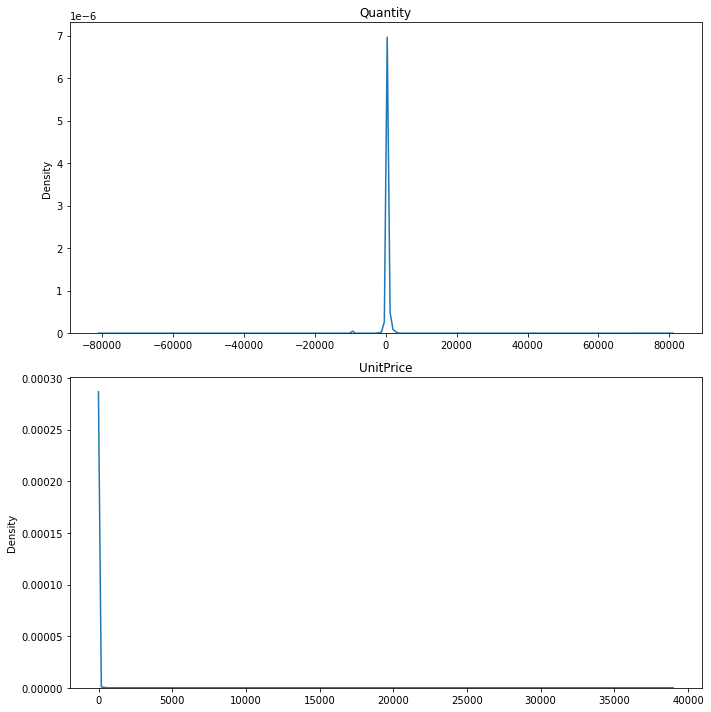

In [6]:
df_numeric = df[['Quantity', 'UnitPrice']]
if not df_numeric.empty:
    n_cols = len(df_numeric.columns)
    plt.figure(figsize=(10, 5 * n_cols))  
    
    for i, col in enumerate(df_numeric.columns, start=1): 
        plt.subplot(n_cols, 1, i)  
        sns.kdeplot(df_numeric[col])
        plt.title(col)
        plt.xlabel('') 

    plt.tight_layout() 
    plt.show()
else:
    print("No numeric columns available in the DataFrame to plot.")

In [7]:
# Check the number of products for each CustomerID and InvoiceNo
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

CustomerID InvoiceNo  Number of products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24
5      12347    556201                  18
6      12347    562032                  22
7      12347    573511                  47
8      12347    581180                  11
9      12348    539318                  17

There are several findouts:
- Cancellation order starts with 'C' prefix in InvoiceNo
- There are customers who buy only once
- There are customers who buy a lot for each item

In [8]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 3654/22190 (16.47%) 


In [9]:
df.sort_values('CustomerID')[:5]

InvoiceNo StockCode                         Description  Quantity  \
61619     541431     23166      MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624    C541433     23166      MEDIUM CERAMIC TOP STORAGE JAR    -74215   
286623    562032     22375   AIRLINE BAG VINTAGE JET SET BROWN         4   
72260     542237     84991         60 TEATIME FAIRY CAKE CASES        24   
14943     537626     22772  PINK DRAWER KNOB ACRYLIC EDWARDIAN        12   

            InvoiceDate  UnitPrice CustomerID         Country  
61619   1/18/2011 10:01       1.04      12346  United Kingdom  
61624   1/18/2011 10:17       1.04      12346  United Kingdom  
286623    8/2/2011 8:48       4.25      12347         Iceland  
72260   1/26/2011 14:30       0.55      12347         Iceland  
14943   12/7/2010 14:57       1.25      12347         Iceland

- The first and the second rows tell us that there are corresponding order row for cancellation order row

Check that every negative quantity is cancellation order

In [10]:
negative_quantity_invoices = df[df['Quantity']<0]['InvoiceNo']
negative_quantity_invoices.str.startswith('C').all()

True

Check that every cancellation order has negative quantity

In [11]:
(df[df['InvoiceNo'].str[0]=='C']['Quantity']<0).all()

True

Now I will create a table that contains each order cancellation and the corresponding order information in one row.

In [12]:
# Check if a row from the cancellation DataFrame has a corresponding row with the same CustomerID and InvoiceNo in the nb_products_per_basket DataFrame

# cancellation : InvoiceNo starts with C
df_pl = pl.DataFrame(df).with_columns(
    pl.col('InvoiceDate').str.strptime(pl.Datetime, "%m/%d/%Y %H:%M"),
    pl.col('CustomerID').cast(pl.Int64)
).sort(['CustomerID', 'InvoiceDate'])
cancellation = (
    df_pl.filter(pl.col("InvoiceNo").str.starts_with("C"))
    .with_columns(-pl.col("Quantity").alias('QuantityCancel'))
)
cancellation.head()

shape: (5, 9)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ InvoiceNo ┆ StockCode ┆ Descripti ┆ Quantity ┆ … ┆ UnitPrice ┆ CustomerI ┆ Country   ┆ QuantityC │
│ ---       ┆ ---       ┆ on        ┆ ---      ┆   ┆ ---       ┆ D         ┆ ---       ┆ ancel     │
│ str       ┆ str       ┆ ---       ┆ i64      ┆   ┆ f64       ┆ ---       ┆ str       ┆ ---       │
│           ┆           ┆ str       ┆          ┆   ┆           ┆ i64       ┆           ┆ i64       │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ C541433   ┆ 23166     ┆ MEDIUM    ┆ -74215   ┆ … ┆ 1.04      ┆ 12346     ┆ United    ┆ 74215     │
│           ┆           ┆ CERAMIC   ┆          ┆   ┆           ┆           ┆ Kingdom   ┆           │
│           ┆           ┆ TOP       ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆           ┆ STORAGE   ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆           ┆ JAR       ┆          ┆   ┆           ┆           ┆           ┆           │
│ C545329   ┆ M         ┆ Manual    ┆ -1       ┆ … ┆ 280.05    ┆ 12352     ┆ Norway    ┆ 1         │
│ C545329   ┆ M         ┆ Manual    ┆ -1       ┆ … ┆ 183.75    ┆ 12352     ┆ Norway    ┆ 1         │
│ C545330   ┆ M         ┆ Manual    ┆ -1       ┆ … ┆ 376.5     ┆ 12352     ┆ Norway    ┆ 1         │
│ C547388   ┆ 22645     ┆ CERAMIC   ┆ -12      ┆ … ┆ 1.45      ┆ 12352     ┆ Norway    ┆ 12        │
│           ┆           ┆ HEART     ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆           ┆ FAIRY     ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆           ┆ CAKE      ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆           ┆ MONEY…    ┆          ┆   ┆           ┆           ┆           ┆           │
└───────────┴───────────┴───────────┴──────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [13]:
# orders: InvoiceNo not starts with C
orders = df_pl.filter(~pl.col("InvoiceNo").str.starts_with("C"))
orders.head()

shape: (5, 8)
┌───────────┬───────────┬──────────────┬──────────┬─────────────┬───────────┬────────────┬─────────┐
│ InvoiceNo ┆ StockCode ┆ Description  ┆ Quantity ┆ InvoiceDate ┆ UnitPrice ┆ CustomerID ┆ Country │
│ ---       ┆ ---       ┆ ---          ┆ ---      ┆ ---         ┆ ---       ┆ ---        ┆ ---     │
│ str       ┆ str       ┆ str          ┆ i64      ┆ datetime[μs ┆ f64       ┆ i64        ┆ str     │
│           ┆           ┆              ┆          ┆ ]           ┆           ┆            ┆         │
╞═══════════╪═══════════╪══════════════╪══════════╪═════════════╪═══════════╪════════════╪═════════╡
│ 541431    ┆ 23166     ┆ MEDIUM       ┆ 74215    ┆ 2011-01-18  ┆ 1.04      ┆ 12346      ┆ United  │
│           ┆           ┆ CERAMIC TOP  ┆          ┆ 10:01:00    ┆           ┆            ┆ Kingdom │
│           ┆           ┆ STORAGE JAR  ┆          ┆             ┆           ┆            ┆         │
│ 537626    ┆ 85116     ┆ BLACK        ┆ 12       ┆ 2010-12-07  ┆ 2.1       ┆ 12347      ┆ Iceland │
│           ┆           ┆ CANDELABRA   ┆          ┆ 14:57:00    ┆           ┆            ┆         │
│           ┆           ┆ T-LIGHT      ┆          ┆             ┆           ┆            ┆         │
│           ┆           ┆ HOLDE…       ┆          ┆             ┆           ┆            ┆         │
│ 537626    ┆ 22375     ┆ AIRLINE BAG  ┆ 4        ┆ 2010-12-07  ┆ 4.25      ┆ 12347      ┆ Iceland │
│           ┆           ┆ VINTAGE JET  ┆          ┆ 14:57:00    ┆           ┆            ┆         │
│           ┆           ┆ SET BR…      ┆          ┆             ┆           ┆            ┆         │
│ 537626    ┆ 71477     ┆ COLOUR       ┆ 12       ┆ 2010-12-07  ┆ 3.25      ┆ 12347      ┆ Iceland │
│           ┆           ┆ GLASS. STAR  ┆          ┆ 14:57:00    ┆           ┆            ┆         │
│           ┆           ┆ T-LIGHT HOL… ┆          ┆             ┆           ┆            ┆         │
│ 537626    ┆ 22492     ┆ MINI PAINT   ┆ 36       ┆ 2010-12-07  ┆ 0.65      ┆ 12347      ┆ Iceland │
│           ┆           ┆ SET VINTAGE  ┆          ┆ 14:57:00    ┆           ┆            ┆         │
└───────────┴───────────┴──────────────┴──────────┴─────────────┴───────────┴────────────┴─────────┘

In [14]:
# Add a unique identifier to orders to track row positions
orders = orders.with_row_index("row_id")
orders = orders.with_columns(pl.lit(0).alias("QuantityCanceled"))
cancellation = cancellation.with_row_index("row_id")

# Initialize lists for entries to remove and doubtful entries
entry_to_remove = []
doubtful_entry = []

# Iterate through the cancellation DataFrame
for row in cancellation.iter_rows(named=True):
    # Skip rows that are not valid cancellations
    if row["Description"] == "Discount":
        continue

    # Filter potential matching orders
    matching_orders = orders.filter(
        (pl.col("CustomerID") == row["CustomerID"]) &
        (pl.col("StockCode") == row["StockCode"]) &
        (pl.col("InvoiceDate") < row["InvoiceDate"]) &
        (pl.col("Quantity") > 0)
    )

    # Case 1: No matching orders
    if matching_orders.is_empty():
        doubtful_entry.append(row["row_id"])

    # Case 2: Exactly one matching order
    elif matching_orders.height == 1:
        order_index = matching_orders["row_id"][0]  # Access the row_id directly
        orders = orders.with_columns(
            pl.when(pl.col("row_id") == order_index)
            .then(-row["Quantity"])
            .otherwise(pl.col("QuantityCanceled"))
            .alias("QuantityCanceled")
        )
        entry_to_remove.append(row["row_id"])

    # Case 3: Multiple matching orders
    elif matching_orders.height > 1:
        # Sort matching orders by InvoiceDate in descending order
        matching_orders = matching_orders.sort("InvoiceDate", descending=True)

        for order_row in matching_orders.iter_rows(named=True):
            if order_row["Quantity"] < -row["Quantity"]:
                continue
            order_index = order_row["row_id"]
            orders = orders.with_columns(
                pl.when(pl.col("row_id") == order_index)
                .then(-row["Quantity"])
                .otherwise(pl.col("QuantityCanceled"))
                .alias("QuantityCanceled")
            )
            entry_to_remove.append(row["row_id"])
            break

In [15]:
len(entry_to_remove), len(doubtful_entry)

(7521, 1226)

In [16]:
remaining_cancel = cancellation.filter(
    ~pl.col("row_id").is_in(entry_to_remove),
    ~pl.col("row_id").is_in(doubtful_entry),
    pl.col("StockCode")!='D'
)
remaining_cancel

shape: (48, 10)
┌────────┬───────────┬───────────┬────────────┬───┬───────────┬────────────┬───────────┬───────────┐
│ row_id ┆ InvoiceNo ┆ StockCode ┆ Descriptio ┆ … ┆ UnitPrice ┆ CustomerID ┆ Country   ┆ QuantityC │
│ ---    ┆ ---       ┆ ---       ┆ n          ┆   ┆ ---       ┆ ---        ┆ ---       ┆ ancel     │
│ u32    ┆ str       ┆ str       ┆ ---        ┆   ┆ f64       ┆ i64        ┆ str       ┆ ---       │
│        ┆           ┆           ┆ str        ┆   ┆           ┆            ┆           ┆ i64       │
╞════════╪═══════════╪═══════════╪════════════╪═══╪═══════════╪════════════╪═══════════╪═══════════╡
│ 475    ┆ C580263   ┆ M         ┆ Manual     ┆ … ┆ 9.95      ┆ 12536      ┆ France    ┆ 4         │
│ 476    ┆ C580263   ┆ M         ┆ Manual     ┆ … ┆ 0.29      ┆ 12536      ┆ France    ┆ 16        │
│ 1000   ┆ C562188   ┆ 85099B    ┆ JUMBO BAG  ┆ … ┆ 1.79      ┆ 12748      ┆ United    ┆ 100       │
│        ┆           ┆           ┆ RED        ┆   ┆           ┆            ┆ Kingdom   ┆           │
│        ┆           ┆           ┆ RETROSPOT  ┆   ┆           ┆            ┆           ┆           │
│ 1141   ┆ C569636   ┆ 23002     ┆ TRAVEL     ┆ … ┆ 0.42      ┆ 12841      ┆ United    ┆ 5         │
│        ┆           ┆           ┆ CARD       ┆   ┆           ┆            ┆ Kingdom   ┆           │
│        ┆           ┆           ┆ WALLET     ┆   ┆           ┆            ┆           ┆           │
│        ┆           ┆           ┆ SKULLS     ┆   ┆           ┆            ┆           ┆           │
│ 1499   ┆ C578832   ┆ 22834     ┆ HAND       ┆ … ┆ 2.1       ┆ 13069      ┆ United    ┆ 32        │
│        ┆           ┆           ┆ WARMER     ┆   ┆           ┆            ┆ Kingdom   ┆           │
│        ┆           ┆           ┆ BABUSHKA   ┆   ┆           ┆            ┆           ┆           │
│        ┆           ┆           ┆ DESIGN     ┆   ┆           ┆            ┆           ┆           │
│ …      ┆ …         ┆ …         ┆ …          ┆ … ┆ …         ┆ …          ┆ …         ┆ …         │
│ 6701   ┆ C546191   ┆ 47566B    ┆ TEA TIME   ┆ … ┆ 0.7       ┆ 16422      ┆ United    ┆ 35        │
│        ┆           ┆           ┆ PARTY      ┆   ┆           ┆            ┆ Kingdom   ┆           │
│        ┆           ┆           ┆ BUNTING    ┆   ┆           ┆            ┆           ┆           │
│ 7341   ┆ C555529   ┆ 22698     ┆ PINK       ┆ … ┆ 2.95      ┆ 16923      ┆ United    ┆ 24        │
│        ┆           ┆           ┆ REGENCY    ┆   ┆           ┆            ┆ Kingdom   ┆           │
│        ┆           ┆           ┆ TEACUP AND ┆   ┆           ┆            ┆           ┆           │
│        ┆           ┆           ┆ SAUCER     ┆   ┆           ┆            ┆           ┆           │
│ 7489   ┆ C574748   ┆ 22382     ┆ LUNCH BAG  ┆ … ┆ 1.45      ┆ 17107      ┆ United    ┆ 100       │
│        ┆           ┆           ┆ SPACEBOY   ┆   ┆           ┆            ┆ Kingdom   ┆           │
│        ┆           ┆           ┆ DESIGN     ┆   ┆           ┆            ┆           ┆           │
│ 8266   ┆ C558110   ┆ 22423     ┆ REGENCY    ┆ … ┆ 12.75     ┆ 17731      ┆ United    ┆ 4         │
│        ┆           ┆           ┆ CAKESTAND  ┆   ┆           ┆            ┆ Kingdom   ┆           │
│        ┆           ┆           ┆ 3 TIER     ┆   ┆           ┆            ┆           ┆           │
│ 8279   ┆ C547675   ┆ 22263     ┆ FELT EGG   ┆ … ┆ 0.66      ┆ 17754      ┆ United    ┆ 49        │
│        ┆           ┆           ┆ COSY       ┆   ┆           ┆            ┆ Kingdom   ┆           │
│        ┆           ┆           ┆ LADYBIRD   ┆   ┆           ┆            ┆           ┆           │
└────────┴───────────┴───────────┴────────────┴───┴───────────┴────────────┴───────────┴───────────┘

Let's look into the third row as a specific example. \
QuantityCancel is 100, but total Quantity ordered is 66 as follows. 

In [17]:
orders.filter(
    pl.col("CustomerID")==12748,
    pl.col("StockCode")=="85099B",
)['Quantity'].sum()

66

So, let's change QuantityCanceled values by checking Quantity

In [18]:
# Change QuantityCanceled values for remaining_cancel
for row in remaining_cancel.iter_rows(named=True):
    # Skip rows that are not valid cancellations
    if row["Description"] == "Discount":
        continue
    # Filter potential matching orders
    matching_orders = orders.filter(
        (pl.col("CustomerID") == row["CustomerID"]) &
        (pl.col("StockCode") == row["StockCode"]) &
        (pl.col("InvoiceDate") < row["InvoiceDate"]) &
        (pl.col("Quantity") > 0)
    )
    for order_row in matching_orders.iter_rows(named=True):
        order_index = order_row["row_id"]
        orders = orders.with_columns(
            pl.when(pl.col("row_id") == order_index)
            .then(order_row["Quantity"])
            .otherwise(pl.col("QuantityCanceled"))
            .alias("QuantityCanceled")
        )

Now orders dataframe has QuantityCanceled column with proper values.

In [19]:
orders.head()

shape: (5, 10)
┌────────┬───────────┬───────────┬────────────┬───┬───────────┬────────────┬───────────┬───────────┐
│ row_id ┆ InvoiceNo ┆ StockCode ┆ Descriptio ┆ … ┆ UnitPrice ┆ CustomerID ┆ Country   ┆ QuantityC │
│ ---    ┆ ---       ┆ ---       ┆ n          ┆   ┆ ---       ┆ ---        ┆ ---       ┆ anceled   │
│ u32    ┆ str       ┆ str       ┆ ---        ┆   ┆ f64       ┆ i64        ┆ str       ┆ ---       │
│        ┆           ┆           ┆ str        ┆   ┆           ┆            ┆           ┆ i32       │
╞════════╪═══════════╪═══════════╪════════════╪═══╪═══════════╪════════════╪═══════════╪═══════════╡
│ 0      ┆ 541431    ┆ 23166     ┆ MEDIUM     ┆ … ┆ 1.04      ┆ 12346      ┆ United    ┆ 74215     │
│        ┆           ┆           ┆ CERAMIC    ┆   ┆           ┆            ┆ Kingdom   ┆           │
│        ┆           ┆           ┆ TOP        ┆   ┆           ┆            ┆           ┆           │
│        ┆           ┆           ┆ STORAGE    ┆   ┆           ┆            ┆           ┆           │
│        ┆           ┆           ┆ JAR        ┆   ┆           ┆            ┆           ┆           │
│ 1      ┆ 537626    ┆ 85116     ┆ BLACK      ┆ … ┆ 2.1       ┆ 12347      ┆ Iceland   ┆ 0         │
│        ┆           ┆           ┆ CANDELABRA ┆   ┆           ┆            ┆           ┆           │
│        ┆           ┆           ┆ T-LIGHT    ┆   ┆           ┆            ┆           ┆           │
│        ┆           ┆           ┆ HOLDE…     ┆   ┆           ┆            ┆           ┆           │
│ 2      ┆ 537626    ┆ 22375     ┆ AIRLINE    ┆ … ┆ 4.25      ┆ 12347      ┆ Iceland   ┆ 0         │
│        ┆           ┆           ┆ BAG        ┆   ┆           ┆            ┆           ┆           │
│        ┆           ┆           ┆ VINTAGE    ┆   ┆           ┆            ┆           ┆           │
│        ┆           ┆           ┆ JET SET    ┆   ┆           ┆            ┆           ┆           │
│        ┆           ┆           ┆ BR…        ┆   ┆           ┆            ┆           ┆           │
│ 3      ┆ 537626    ┆ 71477     ┆ COLOUR     ┆ … ┆ 3.25      ┆ 12347      ┆ Iceland   ┆ 0         │
│        ┆           ┆           ┆ GLASS.     ┆   ┆           ┆            ┆           ┆           │
│        ┆           ┆           ┆ STAR       ┆   ┆           ┆            ┆           ┆           │
│        ┆           ┆           ┆ T-LIGHT    ┆   ┆           ┆            ┆           ┆           │
│        ┆           ┆           ┆ HOL…       ┆   ┆           ┆            ┆           ┆           │
│ 4      ┆ 537626    ┆ 22492     ┆ MINI PAINT ┆ … ┆ 0.65      ┆ 12347      ┆ Iceland   ┆ 0         │
│        ┆           ┆           ┆ SET        ┆   ┆           ┆            ┆           ┆           │
│        ┆           ┆           ┆ VINTAGE    ┆   ┆           ┆            ┆           ┆           │
└────────┴───────────┴───────────┴────────────┴───┴───────────┴────────────┴───────────┴───────────┘

Let's examine the StockCode column. Some entries consist of only letters.

In [20]:
df = orders.to_pandas()
list_special_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'M', 'C2', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

Check descriptions for only letter cases

In [21]:
{code: df[df['StockCode'] == code]['Description'].unique()[0] for code in list_special_codes}

{'POST': 'POSTAGE',
 'M': 'Manual',
 'C2': 'CARRIAGE',
 'BANK CHARGES': 'Bank Charges',
 'PADS': 'PADS TO MATCH ALL CUSHIONS',
 'DOT': 'DOTCOM POSTAGE'}

In [22]:
orders.filter(
    pl.col("StockCode").is_in(list_special_codes)
)

shape: (1_549, 10)
┌────────┬───────────┬───────────┬────────────┬───┬───────────┬────────────┬───────────┬───────────┐
│ row_id ┆ InvoiceNo ┆ StockCode ┆ Descriptio ┆ … ┆ UnitPrice ┆ CustomerID ┆ Country   ┆ QuantityC │
│ ---    ┆ ---       ┆ ---       ┆ n          ┆   ┆ ---       ┆ ---        ┆ ---       ┆ anceled   │
│ u32    ┆ str       ┆ str       ┆ ---        ┆   ┆ f64       ┆ i64        ┆ str       ┆ ---       │
│        ┆           ┆           ┆ str        ┆   ┆           ┆            ┆           ┆ i32       │
╞════════╪═══════════╪═══════════╪════════════╪═══╪═══════════╪════════════╪═══════════╪═══════════╡
│ 187    ┆ 539318    ┆ POST      ┆ POSTAGE    ┆ … ┆ 40.0      ┆ 12348      ┆ Finland   ┆ 0         │
│ 204    ┆ 541998    ┆ POST      ┆ POSTAGE    ┆ … ┆ 40.0      ┆ 12348      ┆ Finland   ┆ 0         │
│ 210    ┆ 548955    ┆ POST      ┆ POSTAGE    ┆ … ┆ 40.0      ┆ 12348      ┆ Finland   ┆ 0         │
│ 213    ┆ 568172    ┆ POST      ┆ POSTAGE    ┆ … ┆ 40.0      ┆ 12348      ┆ Finland   ┆ 0         │
│ 225    ┆ 577609    ┆ POST      ┆ POSTAGE    ┆ … ┆ 300.0     ┆ 12349      ┆ Italy     ┆ 0         │
│ …      ┆ …         ┆ …         ┆ …          ┆ … ┆ …         ┆ …          ┆ …         ┆ …         │
│ 385117 ┆ 577058    ┆ M         ┆ Manual     ┆ … ┆ 0.29      ┆ 18122      ┆ United    ┆ 0         │
│        ┆           ┆           ┆            ┆   ┆           ┆            ┆ Kingdom   ┆           │
│ 385249 ┆ 580054    ┆ M         ┆ Manual     ┆ … ┆ 0.08      ┆ 18122      ┆ United    ┆ 0         │
│        ┆           ┆           ┆            ┆   ┆           ┆            ┆ Kingdom   ┆           │
│ 385536 ┆ 570333    ┆ M         ┆ Manual     ┆ … ┆ 0.39      ┆ 18126      ┆ United    ┆ 0         │
│        ┆           ┆           ┆            ┆   ┆           ┆            ┆ Kingdom   ┆           │
│ 392114 ┆ 550957    ┆ M         ┆ Manual     ┆ … ┆ 1.95      ┆ 18283      ┆ United    ┆ 0         │
│        ┆           ┆           ┆            ┆   ┆           ┆            ┆ Kingdom   ┆           │
│ 392353 ┆ 565579    ┆ M         ┆ Manual     ┆ … ┆ 4.0       ┆ 18283      ┆ United    ┆ 0         │
│        ┆           ┆           ┆            ┆   ┆           ┆            ┆ Kingdom   ┆           │
└────────┴───────────┴───────────┴────────────┴───┴───────────┴────────────┴───────────┴───────────┘

##### 3.2 Order Basket & Total Sale
Now I want to generate new column 'TotalSale'

In [23]:
orders = orders.with_columns(((pl.col('Quantity') - pl.col('QuantityCanceled')) * pl.col('UnitPrice')).alias('TotalSale'))
orders.head()

shape: (5, 11)
┌────────┬───────────┬───────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ row_id ┆ InvoiceNo ┆ StockCode ┆ Descriptio ┆ … ┆ CustomerID ┆ Country   ┆ QuantityC ┆ TotalSale │
│ ---    ┆ ---       ┆ ---       ┆ n          ┆   ┆ ---        ┆ ---       ┆ anceled   ┆ ---       │
│ u32    ┆ str       ┆ str       ┆ ---        ┆   ┆ i64        ┆ str       ┆ ---       ┆ f64       │
│        ┆           ┆           ┆ str        ┆   ┆            ┆           ┆ i32       ┆           │
╞════════╪═══════════╪═══════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 0      ┆ 541431    ┆ 23166     ┆ MEDIUM     ┆ … ┆ 12346      ┆ United    ┆ 74215     ┆ 0.0       │
│        ┆           ┆           ┆ CERAMIC    ┆   ┆            ┆ Kingdom   ┆           ┆           │
│        ┆           ┆           ┆ TOP        ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ STORAGE    ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ JAR        ┆   ┆            ┆           ┆           ┆           │
│ 1      ┆ 537626    ┆ 85116     ┆ BLACK      ┆ … ┆ 12347      ┆ Iceland   ┆ 0         ┆ 25.2      │
│        ┆           ┆           ┆ CANDELABRA ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ T-LIGHT    ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ HOLDE…     ┆   ┆            ┆           ┆           ┆           │
│ 2      ┆ 537626    ┆ 22375     ┆ AIRLINE    ┆ … ┆ 12347      ┆ Iceland   ┆ 0         ┆ 17.0      │
│        ┆           ┆           ┆ BAG        ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ VINTAGE    ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ JET SET    ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ BR…        ┆   ┆            ┆           ┆           ┆           │
│ 3      ┆ 537626    ┆ 71477     ┆ COLOUR     ┆ … ┆ 12347      ┆ Iceland   ┆ 0         ┆ 39.0      │
│        ┆           ┆           ┆ GLASS.     ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ STAR       ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ T-LIGHT    ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ HOL…       ┆   ┆            ┆           ┆           ┆           │
│ 4      ┆ 537626    ┆ 22492     ┆ MINI PAINT ┆ … ┆ 12347      ┆ Iceland   ┆ 0         ┆ 23.4      │
│        ┆           ┆           ┆ SET        ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ VINTAGE    ┆   ┆            ┆           ┆           ┆           │
└────────┴───────────┴───────────┴────────────┴───┴────────────┴───────────┴───────────┴───────────┘

- I can make order_basket by aggregating same InvoiceNo and CustomerID

In [24]:
order_basket = orders.group_by(["InvoiceNo", "CustomerID"]).agg(
    pl.col("TotalSale").sum().alias("TotalSaleSum")
).sort('CustomerID')
order_basket

shape: (18_536, 3)
┌───────────┬────────────┬──────────────┐
│ InvoiceNo ┆ CustomerID ┆ TotalSaleSum │
│ ---       ┆ ---        ┆ ---          │
│ str       ┆ i64        ┆ f64          │
╞═══════════╪════════════╪══════════════╡
│ 541431    ┆ 12346      ┆ 0.0          │
│ 581180    ┆ 12347      ┆ 224.82       │
│ 562032    ┆ 12347      ┆ 584.91       │
│ 537626    ┆ 12347      ┆ 711.79       │
│ 542237    ┆ 12347      ┆ 475.39       │
│ …         ┆ …          ┆ …            │
│ 550957    ┆ 18283      ┆ 115.6        │
│ 556731    ┆ 18283      ┆ 103.72       │
│ 554065    ┆ 18287      ┆ 765.28       │
│ 570715    ┆ 18287      ┆ 1001.32      │
│ 573167    ┆ 18287      ┆ 70.68        │
└───────────┴────────────┴──────────────┘

- Distribution of TotalSaleSum

The distribution shows peaks around specific price points, such as 100 and 300. This pattern may indicate a free delivery policy or a discount policy in effect.

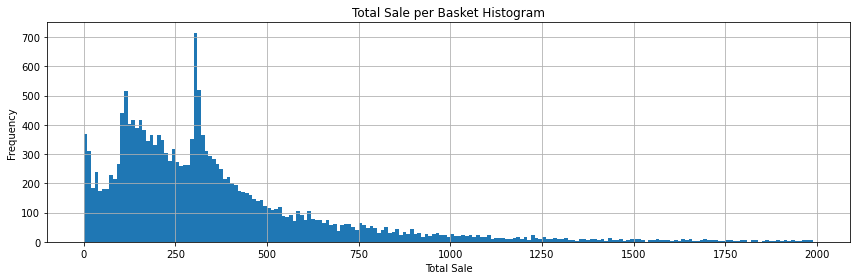

In [25]:
plt.figure(figsize=(12, 4))
plt.hist(order_basket['TotalSaleSum'], bins=np.arange(0, 2000, 10))
plt.grid()
plt.title('Total Sale per Basket Histogram')
plt.xlabel('Total Sale')
plt.ylabel('Frequency')
plt.tight_layout()

- Top customer Contribution to Total Sales

Top customers contribute a significant percentage to total sales, making it crucial to attract and retain high-value customers.

In [26]:
order_customer = orders.group_by(["CustomerID"]).agg(
    pl.col("TotalSale").sum().alias("TotalSaleCustomer")
).sort('CustomerID')
order_customer = order_customer.with_columns(
    (pl.col("TotalSaleCustomer")/order_customer['TotalSaleCustomer'].sum() * 100).alias('SalesPercent')
).sort('SalesPercent', descending=True)

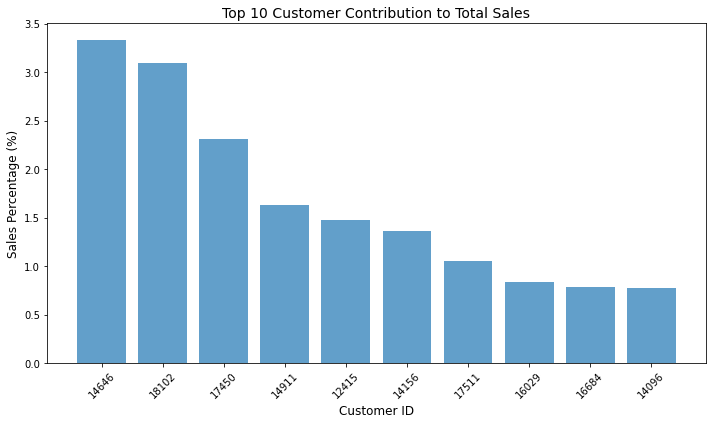

In [27]:
# Visualization
plt.figure(figsize=(10, 6))
plt.bar(order_customer["CustomerID"].cast(pl.String)[:10], order_customer["SalesPercent"][:10], alpha=0.7)
plt.xlabel("Customer ID", fontsize=12)
plt.ylabel("Sales Percentage (%)", fontsize=12)
plt.title("Top 10 Customer Contribution to Total Sales", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

- Top customer cumulative contribution to total sales

In [28]:
def get_top_weight(ratio):
    return order_customer["SalesPercent"][:int(len(order_customer)* (ratio/100))].sum()

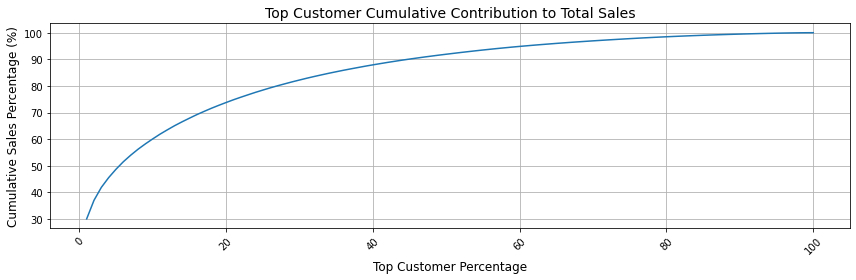

In [29]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, 101), [get_top_weight(i) for i in range(1, 101)])
plt.grid()
plt.xlabel("Top Customer Percentage", fontsize=12)
plt.ylabel("Cumulative Sales Percentage (%)", fontsize=12)
plt.title("Top Customer Cumulative Contribution to Total Sales", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

#### 3.3 Worldmap & Order Counts by Countries

In [30]:
# Group data by CustomerID, InvoiceNo, and Country to count occurrences
world_map = (
    df[['CustomerID', 'InvoiceNo', 'Country']]
    .groupby(['CustomerID', 'InvoiceNo', 'Country'])
    .size()
    .reset_index(name='Count')
)

# Calculate the number of orders per country
countries = world_map['Country'].value_counts()

# Define data for the choropleth map
data = go.Choropleth(
    type='choropleth',
    locations=countries.index,
    locationmode='country names',
    z=countries,
    text=countries.index,
    colorbar=dict(title='Orders'),
    colorscale='Viridis',
    reversescale=False
)

# Define layout for the choropleth map
layout = go.Layout(
    title=dict(
        text="Number of Orders by Countries",
        y=0.9,
        x=0.5,
        xanchor='center',
        yanchor='top'
    ),
    geo=dict(
        resolution=50,
        showocean=True,
        oceancolor='LightBlue',
        showland=True,
        landcolor='whitesmoke',
        showframe=True
    ),
    template='plotly_white',
    height=600,
    width=1000
)

# Create and plot the choropleth map
choromap = go.Figure(data=[data], layout=layout)
iplot(choromap, validate=False)

## 4. Product Category Analysis
In this section, I will generate product categories by keyword distances. I tested different clustering algorithms - K-Means, KMODES, and DBSCAN.

In [31]:
import nltk
from collections import defaultdict
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')  # For POS tagging

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lamor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lamor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

First, let's make list of keywords and analyze it.

In [32]:
# Function definition
def is_noun(pos):
    return pos[:2] == "NN"

def keywords_inventory(array):
    stemmer = nltk.stem.SnowballStemmer("english")
    
    # Initialize structures
    keywords_roots = defaultdict(set)  # root -> set of words
    count_keywords = defaultdict(int)  # root -> frequency
    
    # Iterate through the array
    for s in array:
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)  # Requires punkt
        # Extract nouns and process
        for word, pos in nltk.pos_tag(tokenized):
            if is_noun(pos):
                root = stemmer.stem(word.lower())
                keywords_roots[root].add(word.lower())
                count_keywords[root] += 1

    # Select representative keywords
    keywords_select = {
        root: min(words, key=len) for root, words in keywords_roots.items()
    }
    category_keys = list(keywords_select.values())
    
    # Output summary
    print(f"# of keywords in variable ': {len(category_keys)}")
    return category_keys, dict(keywords_roots), keywords_select, dict(count_keywords)


In [33]:
descriptions = np.array(list(set(orders['Description'].to_numpy())))
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(descriptions)

# of keywords in variable ': 1477


- keywords: The final list of unique keywords.
- keywords_roots: Shows all variations of words grouped by their roots.
- keywords_select: Maps each root to its representative keyword.
- count_keywords: Provides a frequency count of all variations for each root.

In [34]:
def plot_word_occurrences(word_list, top_n=125, figsize=(7, 25)):
    """
    Plots the occurrences of the top N words as a horizontal bar chart.

    Parameters:
        word_list (list of tuples): List of (word, count) pairs.
        top_n (int): Number of top words to display. Default is 125.
        figsize (tuple): Size of the figure. Default is (7, 25).
    """
    # Sort the list by occurrence count (descending order)
    sorted_words = sorted(word_list, key=lambda x: x[1], reverse=True)[:top_n]
    
    # Extract data for the plot
    y_axis = [item[1] for item in sorted_words]  # Occurrence counts
    x_axis = range(len(sorted_words))  # Indices for the top words
    x_labels = [item[0] for item in sorted_words]  # Words
    
    # Create the plot
    plt.rc('font', weight='normal')
    fig, ax = plt.subplots(figsize=figsize)
    
    # Horizontal bar plot
    ax.barh(x_axis, y_axis, align='center', color='skyblue')
    ax.set_yticks(x_axis)
    ax.set_yticklabels(x_labels, fontsize=13)
    ax.invert_yaxis()  # Largest value at the top
    
    # Add labels and title
    ax.set_xlabel("Number of Occurrences", fontsize=18, labelpad=10)
    ax.set_title(
        "Word Occurrence Frequency",
        bbox={'facecolor': 'black', 'pad': 5},
        color='white',
        fontsize=25
    )
    
    # Adjust x-axis font size
    plt.xticks(fontsize=15)
    plt.tight_layout()
    plt.show()

- keyword frequency visualization

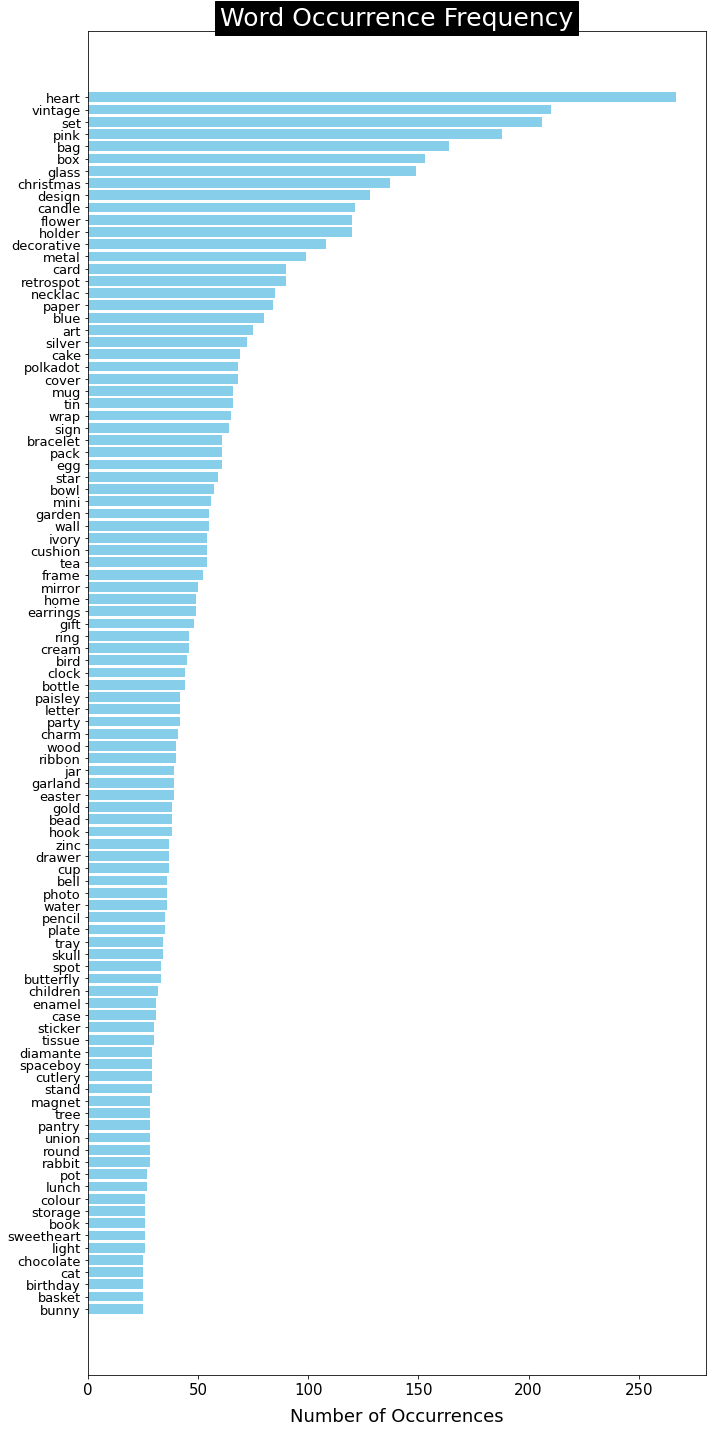

In [61]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)
plot_word_occurrences(list_products, top_n=100, figsize=(10, 20))

Next, I will create tables mapping descriptions to keywords.

The matrix X represents the words present in product descriptions with a one-hot encoding approach.I observed that incorporating price ranges creates more balanced groups concerning the number of elements. Therefore, I add six additional columns to this matrix to indicate the price ranges of the products:

In [62]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)

In [73]:
X = pd.DataFrame({
    key: [int(key.upper() in product) for product in orders['Description'].unique()]
    for key, _ in list_products
})
X.index = orders['Description'].unique()

threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = 'p>{}'.format(threshold[i])
    else:
        col = '{}<p<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0
for i, prod in tqdm(enumerate(orders['Description'].unique())):
    avg_price = orders.filter(pl.col("Description") == prod).select("UnitPrice").mean().to_numpy()[0, 0]
    j = 0
    while avg_price > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[prod, label_col[j-1]] = 1
X

0it [00:00, ?it/s]

heart  vintage  set  bag  box  glass  \
SET 12 COLOUR PENCILS DOLLY GIRL         0        0    0    1    0      0   
TEA TIME TEA TOWELS                      1        0    0    0    1      0   
GREEN CHRISTMAS TREE STRING 20LIGHT      0        0    0    0    0      1   
JUMBO BAG RED RETROSPOT                  0        0    0    0    0      0   
HEART WOODEN CHRISTMAS DECORATION        0        0    0    1    0      0   
...                                    ...      ...  ...  ...  ...    ...   
SET OF TEA COFFEE SUGAR TINS PANTRY      1        0    1    0    0      0   
60 CAKE CASES DOLLY GIRL DESIGN          0        0    0    0    0      0   
BLUE PUDDING SPOON                       0        0    1    0    0      0   
DOLLY GIRL WALL ART                      0        1    1    0    0      0   
DAIRY MAID  PUDDING BOWL                 0        0    0    0    0      0   

                                     christmas  design  candle  flower  ...  \
SET 12 COLOUR PENCILS DOLLY GIRL             0       0       0       0  ...   
TEA TIME TEA TOWELS                          0       1       0       0  ...   
GREEN CHRISTMAS TREE STRING 20LIGHT          0       0       1       0  ...   
JUMBO BAG RED RETROSPOT                      0       0       0       0  ...   
HEART WOODEN CHRISTMAS DECORATION            0       0       0       0  ...   
...                                        ...     ...     ...     ...  ...   
SET OF TEA COFFEE SUGAR TINS PANTRY          0       0       0       0  ...   
60 CAKE CASES DOLLY GIRL DESIGN              0       0       0       0  ...   
BLUE PUDDING SPOON                           0       0       0       0  ...   
DOLLY GIRL WALL ART                          0       0       0       0  ...   
DAIRY MAID  PUDDING BOWL                     0       0       0       0  ...   

                                     tidy  plant  wallet  alphabet  0<p<1  \
SET 12 COLOUR PENCILS DOLLY GIRL        0      0       0         0      1   
TEA TIME TEA TOWELS                     0      0       0         0      0   
GREEN CHRISTMAS TREE STRING 20LIGHT     0      0       0         0      0   
JUMBO BAG RED RETROSPOT                 0      0       0         0      0   
HEART WOODEN CHRISTMAS DECORATION       0      0       0         0      1   
...                                   ...    ...     ...       ...    ...   
SET OF TEA COFFEE SUGAR TINS PANTRY     0      0       0         0      0   
60 CAKE CASES DOLLY GIRL DESIGN         0      0       0         0      1   
BLUE PUDDING SPOON                      0      0       0         0      1   
DOLLY GIRL WALL ART                     0      0       0         0      0   
DAIRY MAID  PUDDING BOWL                0      0       0         0      0   

                                     1<p<2  2<p<3  3<p<5  5<p<10  p>10  
SET 12 COLOUR PENCILS DOLLY GIRL         0      0      0       0     0  
TEA TIME TEA TOWELS                      0      1      0       0     0  
GREEN CHRISTMAS TREE STRING 20LIGHT      0      0      1       0     0  
JUMBO BAG RED RETROSPOT                  0      1      0       0     0  
HEART WOODEN CHRISTMAS DECORATION        0      0      0       0     0  
...                                    ...    ...    ...     ...   ...  
SET OF TEA COFFEE SUGAR TINS PANTRY      0      0      1       0     0  
60 CAKE CASES DOLLY GIRL DESIGN          0      0      0       0     0  
BLUE PUDDING SPOON                       0      0      0       0     0  
DOLLY GIRL WALL ART                      0      0      1       0     0  
DAIRY MAID  PUDDING BOWL                 0      0      1       0     0  

[3877 rows x 197 columns]

- price category and number of products for each category

In [74]:
print("{:<8} {:<20} \n".format('price category', 'number of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = 'p>{}'.format(threshold[i])
    else:
        col = '{}<p<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

price category number of products   
--------------------
0<p<1       964                 
1<p<2       1009                
2<p<3       673                 
3<p<5       606                 
5<p<10      470                 
p>10        155                 


I experimented with three clustering algorithms: K-Means, KModes, and DBSCAN, to determine the most suitable method for segmenting the data.

1. K-Means with Euclidean Distance: \
Initially, I applied K-Means using the Euclidean distance metric, as implemented in the sklearn library. While K-Means is a widely used clustering algorithm, Euclidean distance is not ideal for evaluating similarity in a one-hot encoded matrix, as it does not effectively capture the binary nature of the data.

2. KModes with Hamming Distance: \
To address the limitations of Euclidean distance, I tested KModes, which uses Hamming distance instead. Hamming distance is more appropriate for one-hot encoded vectors as it measures the number of differing elements between binary vectors, providing a better measure of similarity in this context.

3. DBSCAN: \
Lastly, I evaluated DBSCAN (Density-Based Spatial Clustering of Applications with Noise), a density-based clustering algorithm. DBSCAN is particularly effective for identifying clusters of varying shapes and sizes and is robust to noise. However, its performance depends heavily on the choice of hyperparameters, such as eps (maximum distance between points in the same neighborhood) and min_samples (minimum points required to form a cluster).

Each algorithm was tested to evaluate its suitability for clustering the data, considering the unique characteristics of the one-hot encoded matrix and the dataset's structure.

In [75]:
matrix = X.values  # For Pandas, replace with `X.to_numpy()` if necessary

KMEANS with Euclidean

In [ ]:
# Step 1: Determine the optimal number of clusters using silhouette score
print("Determining the optimal number of clusters...")
best_score = -1
optimal_clusters = []
for n_clusters in range(3, 10):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30, random_state=42)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg:.3f}")
    optimal_clusters.append((n_clusters, silhouette_avg))

# Step 2: Select n_clusters = 5 for final clustering
optimal_n_clusters, best_silhouette_score = max(optimal_clusters, key=lambda x: x[1])
print(f"\nPerforming clustering with n_clusters = {optimal_n_clusters}")

silhouette_avg = -1
while silhouette_avg < best_silhouette_score - 0.01:  # Allow slight tolerance for stability
    kmeans = KMeans(init='k-means++', n_clusters=optimal_n_clusters, n_init=30, random_state=42)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print(f"For n_clusters = {optimal_n_clusters}, the average silhouette_score is: {silhouette_avg:.3f}")

# Step 3: Save clustering results
print("\nClustering completed. Assigning clusters to products...")
X['Cluster_KMEANS'] = clusters

Determining the optimal number of clusters...
For n_clusters = 3, the average silhouette_score is: 0.101
For n_clusters = 4, the average silhouette_score is: 0.127
For n_clusters = 5, the average silhouette_score is: 0.147
For n_clusters = 6, the average silhouette_score is: 0.146
For n_clusters = 7, the average silhouette_score is: 0.148
For n_clusters = 8, the average silhouette_score is: 0.149
For n_clusters = 9, the average silhouette_score is: 0.154

Performing clustering with n_clusters = 9
For n_clusters = 9, the average silhouette_score is: 0.154

Clustering completed. Assigning clusters to products...


In [ ]:
# Step 1: Determine the optimal number of clusters using silhouette score
print("Determining the optimal number of clusters using KModes with Hamming's metric...")
optimal_clusters = []
for n_clusters in range(3, 10):
    km = KModes(n_clusters=n_clusters, init='Huang', n_init=30, verbose=0, n_jobs=-1)
    clusters = km.fit_predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters, metric="hamming")
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg:.3f}")
    optimal_clusters.append((n_clusters, silhouette_avg))

# Select the n_clusters with the highest silhouette score
optimal_n_clusters, best_silhouette_score = max(optimal_clusters, key=lambda x: x[1])
print(f"\nOptimal number of clusters: {optimal_n_clusters}, with silhouette score: {best_silhouette_score:.3f}")

# Step 2: Perform final clustering with the optimal number of clusters
print(f"\nPerforming clustering with n_clusters = {optimal_n_clusters} using KModes")
silhouette_avg = -1
while silhouette_avg < best_silhouette_score - 0.01:  # Allow slight tolerance for stability
    km = KModes(n_clusters=optimal_n_clusters, init='Huang', n_init=30, verbose=0, n_jobs=-1)
    clusters = km.fit_predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters, metric="hamming")
    print(f"For n_clusters = {optimal_n_clusters}, the average silhouette_score is: {silhouette_avg:.3f}")

# Step 3: Save clustering results
print("\nClustering completed. Assigning clusters to products...")
X['Cluster_KMODES'] = clusters


Determining the optimal number of clusters using KModes with Hamming's metric...
For n_clusters = 3, the average silhouette_score is: 0.176
For n_clusters = 4, the average silhouette_score is: 0.222
For n_clusters = 5, the average silhouette_score is: 0.258
For n_clusters = 6, the average silhouette_score is: 0.256
For n_clusters = 7, the average silhouette_score is: 0.226
For n_clusters = 8, the average silhouette_score is: 0.208
For n_clusters = 9, the average silhouette_score is: 0.253

Optimal number of clusters: 5, with silhouette score: 0.258

Performing clustering with n_clusters = 5 using KModes
For n_clusters = 5, the average silhouette_score is: 0.260

Clustering completed. Assigning clusters to products...


In [53]:
# Step 1: Compute pairwise Hamming distances
print("Computing pairwise Hamming distances...")
hamming_dist = pairwise_distances(matrix, metric="hamming")

# Step 2: Optimize DBSCAN parameters
print("\nDetermining the optimal parameters for DBSCAN...")
best_silhouette_score = -1
optimal_eps = None
optimal_min_samples = None
min_samples = 5
# Grid search over eps and min_samples
for eps in np.arange(0.01, 0.02, 0.001):
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric="precomputed", n_jobs=-1)
    clusters = clustering.fit_predict(hamming_dist)
    
    # Ignore cases where all points are noise
    unique_clusters = set(clusters)
    if len(unique_clusters - {-1}) < 3:
        continue
    if len(unique_clusters - {-1}) >=10:
        continue
    
    silhouette_avg = silhouette_score(hamming_dist, clusters, metric="precomputed")
    print(f"For eps = {eps}, min_samples = {min_samples}, the silhouette_score is: {silhouette_avg:.3f}")
    
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        optimal_eps = eps
        optimal_min_samples = min_samples

# Fallback if no valid parameters found
if optimal_eps is None or optimal_min_samples is None:
    print("\nNo valid clustering found during grid search. Using fallback parameters.")
    optimal_eps = 0.3  # Default fallback eps
    optimal_min_samples = 5  # Default fallback min_samples
    best_silhouette_score = 0  # Assume silhouette score is 0 for fallback

print(f"\nOptimal DBSCAN parameters: eps = {optimal_eps}, min_samples = {optimal_min_samples}")
print(f"Best silhouette score: {best_silhouette_score:.3f}")

# Step 3: Final clustering with optimal parameters
print("\nPerforming final clustering with optimal DBSCAN parameters...")
clustering = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples, metric="precomputed", n_jobs=-1)
clusters = clustering.fit_predict(hamming_dist)

# Step 4: Save clustering results
print("\nClustering completed. Assigning clusters to products...")
X['Cluster_DBSCAN'] = clusters

# Optional: Analyze noise points
noise_count = sum(clusters == -1)
print(f"\nNumber of noise points (not assigned to any cluster): {noise_count}")
X['Cluster_DBSCAN'].value_counts()

Computing pairwise Hamming distances...

Determining the optimal parameters for DBSCAN...
For eps = 0.011, min_samples = 5, the silhouette_score is: -0.001
For eps = 0.011999999999999999, min_samples = 5, the silhouette_score is: -0.001
For eps = 0.012999999999999998, min_samples = 5, the silhouette_score is: -0.001
For eps = 0.013999999999999997, min_samples = 5, the silhouette_score is: -0.001
For eps = 0.014999999999999996, min_samples = 5, the silhouette_score is: -0.001

Optimal DBSCAN parameters: eps = 0.011, min_samples = 5
Best silhouette score: -0.001

Performing final clustering with optimal DBSCAN parameters...

Clustering completed. Assigning clusters to products...

Number of noise points (not assigned to any cluster): 331


 0    3486
-1     331
 3      13
 1      12
 2       8
 4       7
 7       5
 5       5
 8       5
 6       5
Name: Cluster_DBSCAN, dtype: int64

To evaluate the performance of each clustering algorithm, I calculated the Silhouette score for the resulting clusters. The Silhouette score measures how similar each data point is to its assigned cluster compared to other clusters. Higher scores indicate better-defined clusters.

In the figures, both K-Means and KModes achieved similar Silhouette scores, suggesting comparable clustering performance. On the other hand, DBSCAN demonstrated relatively lower scores, indicating that it underperforms compared to the other two algorithms for this dataset.

This evaluation highlights that K-Means and KModes are better choices for this problem, given their ability to generate more cohesive and well-separated clusters.

In [38]:
import matplotlib as mpl
from matplotlib import cm
from sklearn.metrics import silhouette_samples

def graph_component_silhouette(matrix, clusters):
    """
    Enhanced silhouette plot with dynamic axis adjustments and average silhouette score line.
    """
    n_clusters = len(np.unique(clusters))
    sample_silhouette_values = silhouette_samples(matrix, clusters)
    mat_size=len(matrix)

    # Set plotting style
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor='dimgray', linewidth=1)

    # Create figure
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
    
    # Dynamic x-axis limits based on silhouette scores
    lim_x = [
        min(sample_silhouette_values) - 0.05,
        max(sample_silhouette_values) + 0.05
    ]
    ax1.set_xlim(lim_x)
    
    # Set y-axis range
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    
    # Initialize variables
    y_lower = 10
    cmap = cm.get_cmap("Spectral")
    
    for i in range(n_clusters):
        # Extract and sort silhouette values for the cluster
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        
        # Determine cluster size and y-axis range
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Get color for the cluster
        color = cmap(float(i) / n_clusters)
        
        # Plot the silhouette for the cluster
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.8
        )
        
        # Add cluster label
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i),
                 color='red', fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        
        # Update y_lower for next cluster
        y_lower = y_upper + 10
    
    # Compute and plot the average silhouette score line
    avg_silhouette = np.mean(sample_silhouette_values)
    ax1.axvline(x=avg_silhouette, color="red", linestyle="--", label=f"Average silhouette {np.round(avg_silhouette, 3)}")
    
    # Add title and labels
    ax1.set_title("Silhouette Plot for Clustering", fontsize=16)
    ax1.set_xlabel("Silhouette Coefficient", fontsize=12)
    ax1.set_ylabel("Cluster", fontsize=12)
    ax1.legend(loc="upper right", fontsize=10)

    # Display the plot
    plt.tight_layout()
    plt.show()

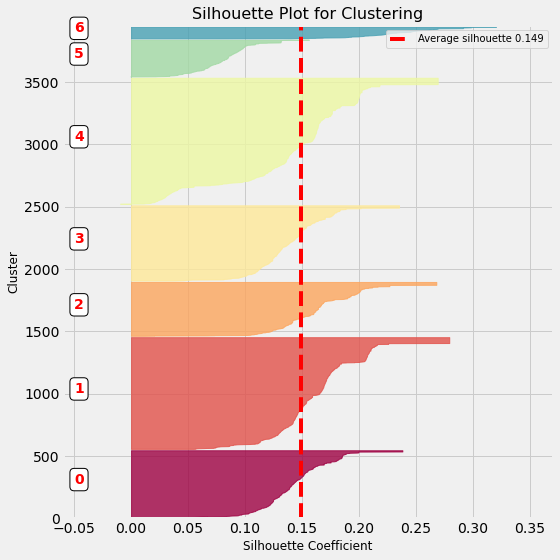

In [74]:
# Plot silhouette with improvements
graph_component_silhouette(matrix=matrix, clusters=X['Cluster_KMEANS'])

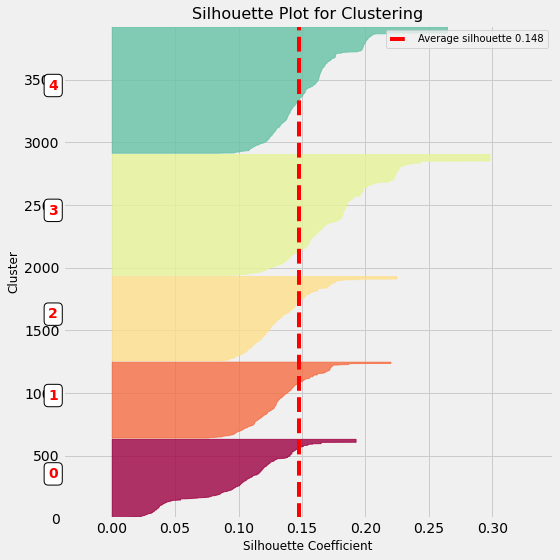

In [75]:
graph_component_silhouette(matrix=matrix, clusters=X['Cluster_KMODES'])

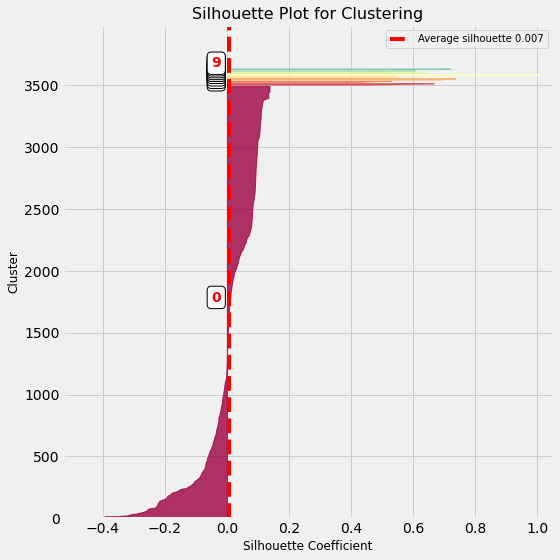

In [76]:
graph_component_silhouette(matrix=matrix, clusters=X['Cluster_DBSCAN'])

In [81]:
# X.to_csv('product_cluster.csv')
# if X is None:
X = pd.read_csv('product_cluster.csv', index_col=0)
matrix = X.values

In [82]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

c:\Users\lamor\anaconda3\envs\py39_64\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



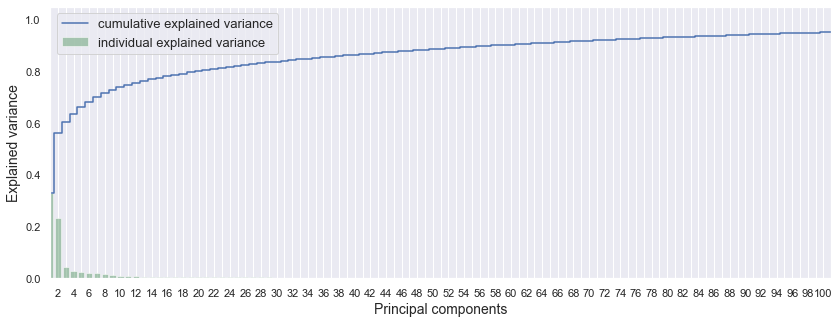

In [83]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set_theme(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.grid()
plt.legend(loc='upper left', fontsize = 13)

## 5. Customer Segmentation by Product Categories

In this section, I focus on segmenting customers based on their purchasing behaviors. Specifically, I calculate the sales weight of different product categories for each customer. This involves determining the proportion of each customer's total spending attributed to various product categories, which serves as the basis for segmentation.

From the previous section, I observed that both K-Means and KModes are effective algorithms for product categorization. Therefore, I leveraged the results of these clustering techniques to enrich the categorization of products. Using this categorized product data, I proceeded to cluster customers using K-Means.

Once the customer clusters were formed, I analyzed the purchasing patterns of each group. This analysis helps to identify distinct customer segments, their preferences, and key characteristics, providing valuable insights for targeted marketing strategies and improving customer relationship management.

This approach enables a deeper understanding of customer behavior, allowing for personalized recommendations and more effective business decisions.

In [84]:
corresp_kmeans = dict()
corresp_kmodes = dict()
for key, val1, val2 in zip (list(X.index), X['Cluster_KMEANS'].values, X['Cluster_KMODES'].values):
    # print(key, val1, val2)
    corresp_kmeans[key] = val1
    corresp_kmodes[key] = val2

In [85]:
orders = orders.with_columns(
    pl.col("Description").map_elements(lambda x: corresp_kmeans.get(x, None), return_dtype=pl.Int8).alias("kmeans_cluster"),
    pl.col("Description").map_elements(lambda x: corresp_kmodes.get(x, None), return_dtype=pl.Int8).alias("kmodes_cluster")
)
orders

shape: (392_732, 13)
┌────────┬───────────┬───────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ row_id ┆ InvoiceNo ┆ StockCode ┆ Descriptio ┆ … ┆ QuantityCa ┆ TotalSale ┆ kmeans_cl ┆ kmodes_cl │
│ ---    ┆ ---       ┆ ---       ┆ n          ┆   ┆ nceled     ┆ ---       ┆ uster     ┆ uster     │
│ u32    ┆ str       ┆ str       ┆ ---        ┆   ┆ ---        ┆ f64       ┆ ---       ┆ ---       │
│        ┆           ┆           ┆ str        ┆   ┆ i32        ┆           ┆ i8        ┆ i8        │
╞════════╪═══════════╪═══════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 0      ┆ 541431    ┆ 23166     ┆ MEDIUM     ┆ … ┆ 74215      ┆ 0.0       ┆ 4         ┆ 3         │
│        ┆           ┆           ┆ CERAMIC    ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ TOP        ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ STORAGE    ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ JAR        ┆   ┆            ┆           ┆           ┆           │
│ 1      ┆ 537626    ┆ 85116     ┆ BLACK      ┆ … ┆ 0          ┆ 25.2      ┆ 5         ┆ 3         │
│        ┆           ┆           ┆ CANDELABRA ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ T-LIGHT    ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ HOLDE…     ┆   ┆            ┆           ┆           ┆           │
│ 2      ┆ 537626    ┆ 22375     ┆ AIRLINE    ┆ … ┆ 0          ┆ 17.0      ┆ 1         ┆ 4         │
│        ┆           ┆           ┆ BAG        ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ VINTAGE    ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ JET SET    ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ BR…        ┆   ┆            ┆           ┆           ┆           │
│ 3      ┆ 537626    ┆ 71477     ┆ COLOUR     ┆ … ┆ 0          ┆ 39.0      ┆ 2         ┆ 0         │
│        ┆           ┆           ┆ GLASS.     ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ STAR       ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ T-LIGHT    ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ HOL…       ┆   ┆            ┆           ┆           ┆           │
│ 4      ┆ 537626    ┆ 22492     ┆ MINI PAINT ┆ … ┆ 0          ┆ 23.4      ┆ 4         ┆ 3         │
│        ┆           ┆           ┆ SET        ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ VINTAGE    ┆   ┆            ┆           ┆           ┆           │
│ …      ┆ …         ┆ …         ┆ …          ┆ … ┆ …          ┆ …         ┆ …         ┆ …         │
│ 392727 ┆ 570715    ┆ 22600     ┆ CHRISTMAS  ┆ … ┆ 0          ┆ 20.4      ┆ 3         ┆ 2         │
│        ┆           ┆           ┆ RETROSPOT  ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ STAR WOOD  ┆   ┆            ┆           ┆           ┆           │
│ 392728 ┆ 570715    ┆ 22603     ┆ CHRISTMAS  ┆ … ┆ 0          ┆ 20.4      ┆ 4         ┆ 3         │
│        ┆           ┆           ┆ RETROSPOT  ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ TREE WOOD  ┆   ┆            ┆           ┆           ┆           │
│ 392729 ┆ 573167    ┆ 23264     ┆ SET OF 3   ┆ … ┆ 0          ┆ 45.0      ┆ 4         ┆ 3         │
│        ┆           ┆           ┆ WOODEN     ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ SLEIGH     ┆   ┆            ┆           ┆           ┆           │
│        ┆           ┆           ┆ DECORAT…   ┆   ┆            ┆           ┆           ┆           │
│ 392730 ┆ 573167    ┆ 21824     ┆ PAINT

In [86]:
k_means_range = 7
k_modes_range = 5

# Add k_means_category_{i} columns
for i in range(k_means_range):
    orders = orders.with_columns(
        (pl.when(pl.col("kmeans_cluster") == i)
         .then(pl.col("TotalSale"))
         .otherwise(0)
         .alias(f"k_means_category_{i}"))
    )
# Add k_modes_category_{j} columns
for j in range(k_modes_range):
    orders = orders.with_columns(
        (pl.when(pl.col("kmodes_cluster") == j)
         .then(pl.col("TotalSale"))
         .otherwise(0)
         .alias(f"k_modes_category_{j}"))
    )

In [87]:
# orders_train = orders.filter(orders["InvoiceDate"] < datetime.datetime(2011, 12, 9, 12, 50))
# orders_test = orders.filter(orders["InvoiceDate"] >= datetime.datetime(2011, 12, 9, 12, 50))

In [172]:
orders_basket_train = orders.group_by(["CustomerID", "InvoiceNo"]).agg(
    pl.col("InvoiceDate").first(),
    pl.col("TotalSale").sum(),
    *[pl.col(f"k_means_category_{i}").sum() for i in range(7)],
    *[pl.col(f"k_modes_category_{i}").sum() for i in range(5)],
).sort(["CustomerID", "InvoiceNo"])
orders_basket_train.head()

shape: (5, 16)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ CustomerI ┆ InvoiceNo ┆ InvoiceDa ┆ TotalSale ┆ … ┆ k_modes_c ┆ k_modes_c ┆ k_modes_c ┆ k_modes_ │
│ D         ┆ ---       ┆ te        ┆ ---       ┆   ┆ ategory_1 ┆ ategory_2 ┆ ategory_3 ┆ category │
│ ---       ┆ str       ┆ ---       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ _4       │
│ i64       ┆           ┆ datetime[ ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆           ┆ μs]       ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 12346     ┆ 541431    ┆ 2011-01-1 ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│           ┆           ┆ 8         ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ 10:01:00  ┆           ┆   ┆           ┆           ┆           ┆          │
│ 12347     ┆ 537626    ┆ 2010-12-0 ┆ 711.79    ┆ … ┆ 60.0      ┆ 224.19    ┆ 120.5     ┆ 185.6    │
│           ┆           ┆ 7         ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ 14:57:00  ┆           ┆   ┆           ┆           ┆           ┆          │
│ 12347     ┆ 542237    ┆ 2011-01-2 ┆ 475.39    ┆ … ┆ 27.5      ┆ 102.0     ┆ 67.6      ┆ 103.7    │
│           ┆           ┆ 6         ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ 14:30:00  ┆           ┆   ┆           ┆           ┆           ┆          │
│ 12347     ┆ 549222    ┆ 2011-04-0 ┆ 636.25    ┆ … ┆ 80.0      ┆ 305.1     ┆ 102.6     ┆ 54.5     │
│           ┆           ┆ 7         ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ 10:43:00  ┆           ┆   ┆           ┆           ┆           ┆          │
│ 12347     ┆ 556201    ┆ 2011-06-0 ┆ 382.52    ┆ … ┆ 57.92     ┆ 63.9      ┆ 81.8      ┆ 98.5     │
│           ┆           ┆ 9         ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ 13:01:00  ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [173]:
last_date = orders["InvoiceDate"].max()
temp = (
    orders.group_by("CustomerID")
    .agg(
        pl.col("TotalSale").sum(),
        (last_date - pl.col("InvoiceDate").max()).dt.total_days().alias('LastDate'),
        (last_date - pl.col("InvoiceDate").min()).dt.total_days().alias('FirstDate'),
        *[pl.col(f"k_means_category_{i}").sum() for i in range(7)],
        *[pl.col(f"k_modes_category_{i}").sum() for i in range(5)],
    ).sort("CustomerID")
    .with_columns(
        *[pl.col(f"k_means_category_{i}")/pl.col("TotalSale") for i in range(7)],
        *[pl.col(f"k_modes_category_{i}")/pl.col("TotalSale") for i in range(5)],

    )
)
customer = (
    orders_basket_train.group_by("CustomerID")
    .agg(
        pl.col("TotalSale").min().alias('min'),
        pl.col("TotalSale").max().alias('max'),
        pl.col("TotalSale").mean().alias('mean'),
        pl.col("TotalSale").count().alias('count'),
    )
    .join(temp, on='CustomerID', how='full', coalesce=True).sort('CustomerID')
    .filter(
        pl.col("TotalSale") > 0
    )
)
customer

shape: (4_327, 20)
┌────────────┬─────────┬─────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ CustomerID ┆ min     ┆ max     ┆ mean       ┆ … ┆ k_modes_ca ┆ k_modes_c ┆ k_modes_c ┆ k_modes_c │
│ ---        ┆ ---     ┆ ---     ┆ ---        ┆   ┆ tegory_1   ┆ ategory_2 ┆ ategory_3 ┆ ategory_4 │
│ i64        ┆ f64     ┆ f64     ┆ f64        ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│            ┆         ┆         ┆            ┆   ┆ f64        ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪═════════╪═════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 12347      ┆ 224.82  ┆ 1294.32 ┆ 615.714286 ┆ … ┆ 0.122566   ┆ 0.274684  ┆ 0.196483  ┆ 0.185197  │
│ 12348      ┆ 227.44  ┆ 892.8   ┆ 449.31     ┆ … ┆ 0.023236   ┆ 0.095346  ┆ 0.170907  ┆ 0.671786  │
│ 12349      ┆ 1757.55 ┆ 1757.55 ┆ 1757.55    ┆ … ┆ 0.119792   ┆ 0.119843  ┆ 0.150795  ┆ 0.429097  │
│ 12350      ┆ 334.4   ┆ 334.4   ┆ 334.4      ┆ … ┆ 0.173146   ┆ 0.0       ┆ 0.2189    ┆ 0.532596  │
│ 12352      ┆ 0.0     ┆ 840.3   ┆ 298.21375  ┆ … ┆ 0.080324   ┆ 0.091315  ┆ 0.503406  ┆ 0.205054  │
│ …          ┆ …       ┆ …       ┆ …          ┆ … ┆ …          ┆ …         ┆ …         ┆ …         │
│ 18280      ┆ 180.6   ┆ 180.6   ┆ 180.6      ┆ … ┆ 0.313953   ┆ 0.130676  ┆ 0.208195  ┆ 0.26412   │
│ 18281      ┆ 80.82   ┆ 80.82   ┆ 80.82      ┆ … ┆ 0.18931    ┆ 0.476244  ┆ 0.334447  ┆ 0.0       │
│ 18282      ┆ 77.84   ┆ 98.76   ┆ 88.3       ┆ … ┆ 0.028539   ┆ 0.070612  ┆ 0.462005  ┆ 0.194224  │
│ 18283      ┆ 1.95    ┆ 307.05  ┆ 127.845625 ┆ … ┆ 0.131511   ┆ 0.174326  ┆ 0.252585  ┆ 0.308111  │
│ 18287      ┆ 70.68   ┆ 1001.32 ┆ 612.426667 ┆ … ┆ 0.05568    ┆ 0.296678  ┆ 0.214861  ┆ 0.301217  │
└────────────┴─────────┴─────────┴────────────┴───┴────────────┴───────────┴───────────┴───────────┘

In [174]:
n1 = len(customer.filter(pl.col("count")==1))
n2 = len(customer)
n1, n2, n1/n2*100

(1482, 4327, 34.25005777675064)

In [175]:
list_cols = ['count','min','max','mean', 'TotalSale'] + [f'k_means_category_{i}' for i in range(7)] + [f'k_modes_category_{i}' for i in range(5)]
matrix = customer[list_cols].to_numpy()
scaler = StandardScaler()
scaler.fit(matrix)
scaled_matrix = scaler.transform(matrix)
scaled_matrix

array([[ 3.52502278e-01, -3.52102236e-02,  6.29584327e-01, ...,
         7.97780419e-01, -3.39997579e-01, -5.06669221e-01],
       [-3.64337246e-02, -2.65668577e-02,  2.76312233e-01, ...,
        -6.31487398e-01, -5.28887316e-01,  2.79786028e+00],
       [-4.25369727e-01,  5.02125778e+00,  1.03715115e+00, ...,
        -4.36256111e-01, -6.77417776e-01,  1.14971034e+00],
       ...,
       [-2.95724393e-01, -5.20096451e-01, -4.22313423e-01, ...,
        -8.28614514e-01,  1.62098837e+00, -4.45364734e-01],
       [ 1.51931029e+00, -7.70457151e-01, -2.39052205e-01, ...,
        -2.04030465e-03,  7.43404500e-02,  3.28064493e-01],
       [-1.66079059e-01, -5.43717252e-01,  3.71792129e-01, ...,
         9.73059439e-01, -2.04264983e-01,  2.81246902e-01]])

In [195]:
best_silhouette = 0
best_cluster = None
for n_clusters in tqdm(range(3, 15)):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(scaled_matrix)
    clusters_customers = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters_customers)
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_cluster = clusters_customers
        best_n_clusters = n_clusters
silhouette_avg = best_silhouette 
clusters_customers = best_cluster
n_clusters = best_n_clusters
print(best_n_clusters, silhouette_avg)

  0%|          | 0/12 [00:00<?, ?it/s]

11 0.23127923383331211


In [196]:
customer_cluster_num = pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['number of customer'])
customer_cluster_num.T

1    10   3    8    0    6    7    9   2   5   4 
number of customer  2538  419  306  295  295  177  123  105  33  32   4

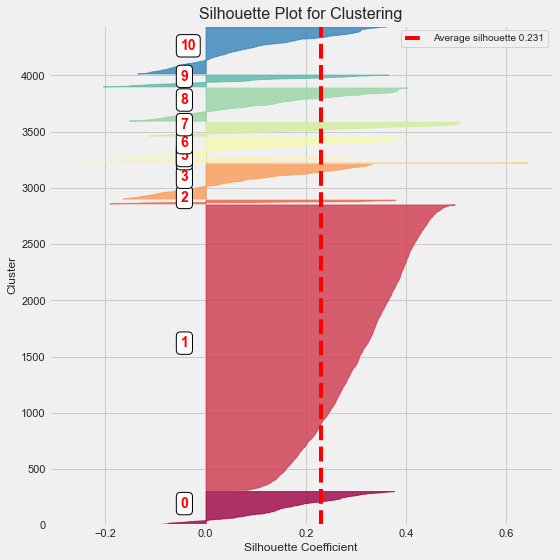

In [197]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_customers)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_customers)
#__________________
# and do the graph
graph_component_silhouette(matrix=scaled_matrix, clusters=clusters_customers)

In [198]:
customer = customer.with_columns(cluster=clusters_customers)
customer_cluster = customer.group_by("cluster").agg(
    *[pl.col(f"k_means_category_{i}").mean() for i in range(7)],
    *[pl.col(f"k_modes_category_{i}").mean() for i in range(5)],
    *[(pl.col('TotalSale') * pl.col(f"k_means_category_{i}")).sum().alias(f'TotalSale_KMEANS{i}') for i in range(7)],
    *[(pl.col('TotalSale') * pl.col(f"k_modes_category_{i}")).sum().alias(f'TotalSale_KMODES{i}') for i in range(5)],
    pl.col('TotalSale').sum()
).with_columns(
    pl.col('cluster').map_elements(lambda x: customer_cluster_num.loc[x].values[0], return_dtype=pl.Int32).alias('cluster_num')
).sort('cluster_num', descending=True)
customer_cluster

shape: (11, 27)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ cluster ┆ k_means_ca ┆ k_means_c ┆ k_means_c ┆ … ┆ TotalSale ┆ TotalSale ┆ TotalSale ┆ cluster_n │
│ ---     ┆ tegory_0   ┆ ategory_1 ┆ ategory_2 ┆   ┆ _KMODES3  ┆ _KMODES4  ┆ ---       ┆ um        │
│ i32     ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ ---       │
│         ┆ f64        ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆           ┆ i32       │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1       ┆ 0.131808   ┆ 0.217392  ┆ 0.121723  ┆ … ┆ 1.0010e6  ┆ 1.0559e6  ┆ 4.1333e6  ┆ 2538      │
│ 10      ┆ 0.088706   ┆ 0.138905  ┆ 0.074996  ┆ … ┆ 154159.92 ┆ 58613.78  ┆ 324169.37 ┆ 419       │
│ 3       ┆ 0.103056   ┆ 0.148088  ┆ 0.368418  ┆ … ┆ 45234.58  ┆ 48400.15  ┆ 265279.76 ┆ 306       │
│ 8       ┆ 0.070433   ┆ 0.545903  ┆ 0.070504  ┆ … ┆ 35990.23  ┆ 135762.64 ┆ 242873.00 ┆ 295       │
│         ┆            ┆           ┆           ┆   ┆           ┆ 1         ┆ 2         ┆           │
│ 0       ┆ 0.107986   ┆ 0.180541  ┆ 0.097318  ┆ … ┆ 114604.15 ┆ 158095.07 ┆ 494488.76 ┆ 295       │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 7       ┆ 0.047205   ┆ 0.097067  ┆ 0.062869  ┆ … ┆ 12291.82  ┆ 8570.14   ┆ 101943.84 ┆ 123       │
│ 9       ┆ 0.118608   ┆ 0.236301  ┆ 0.124742  ┆ … ┆ 90842.71  ┆ 92896.801 ┆ 347172.21 ┆ 105       │
│         ┆            ┆           ┆           ┆   ┆           ┆           ┆ 1         ┆           │
│ 2       ┆ 0.083567   ┆ 0.031198  ┆ 0.013384  ┆ … ┆ 2398.39   ┆ 6192.15   ┆ 18831.8   ┆ 33        │
│ 5       ┆ 0.098741   ┆ 0.227606  ┆ 0.151672  ┆ … ┆ 365389.07 ┆ 420094.3  ┆ 1.4899e6  ┆ 32        │
│ 4       ┆ 0.13684    ┆ 0.222184  ┆ 0.130571  ┆ … ┆ 195313.42 ┆ 217952.07 ┆ 856478.13 ┆ 4         │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

- Total Sales by Cluster

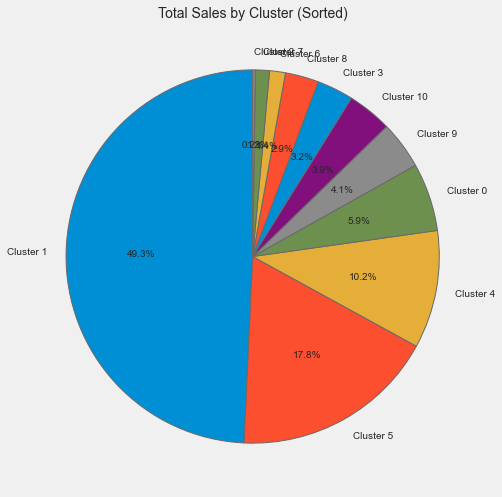

In [199]:
sorted_data = sorted(zip(customer_cluster['TotalSale'], customer_cluster['cluster']), reverse=True)
sorted_sales, sorted_clusters = zip(*sorted_data)

def format_percentage(pct):
    return f"{pct:.1f}%"

# Create a pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    sorted_sales, 
    labels=[f"Cluster {cluster}" for cluster in sorted_clusters], 
    autopct=format_percentage,  # Format percentages in scientific notation
    startangle=90,  # Start angle for better aesthetics
    textprops={'fontsize': 10},  # Text formatting
)

# Title and display
plt.title("Total Sales by Cluster (Sorted)", fontsize=14)
plt.show()

- KMEANS product categorical weight for each group

In [200]:
def plot_radar_chart(categories):
    # Subplot parameters
    num_clusters = len(customer_cluster)
    cols = 3
    rows = (num_clusters + cols - 1) // cols  # Calculate the number of rows needed

    # Create subplots
    fig, axs = plt.subplots(rows, cols, figsize=(20, rows * 5), subplot_kw=dict(polar=True))
    axs = axs.flatten()  # Flatten to 1D for easier indexing

    for i, row in enumerate(customer_cluster.iter_rows(named=True)):
        cluster_id = row["cluster"]
        cluster_num = customer_cluster_num.loc[cluster_id].values[0]
        values = [row[cat] for cat in categories]  # Exclude the 'cluster' column
        values += values[:1]  # Close the radar chart loop
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]

        # Plot radar chart for the current cluster
        ax = axs[i]
        ax.fill(angles, values, color="blue", alpha=0.25)
        ax.plot(angles, values, color="blue", linewidth=2)
        # ax.set_yticks([])
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_title(f"Cluster {cluster_id} (#={cluster_num})", fontsize=14, y=1.1)

    # Turn off unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

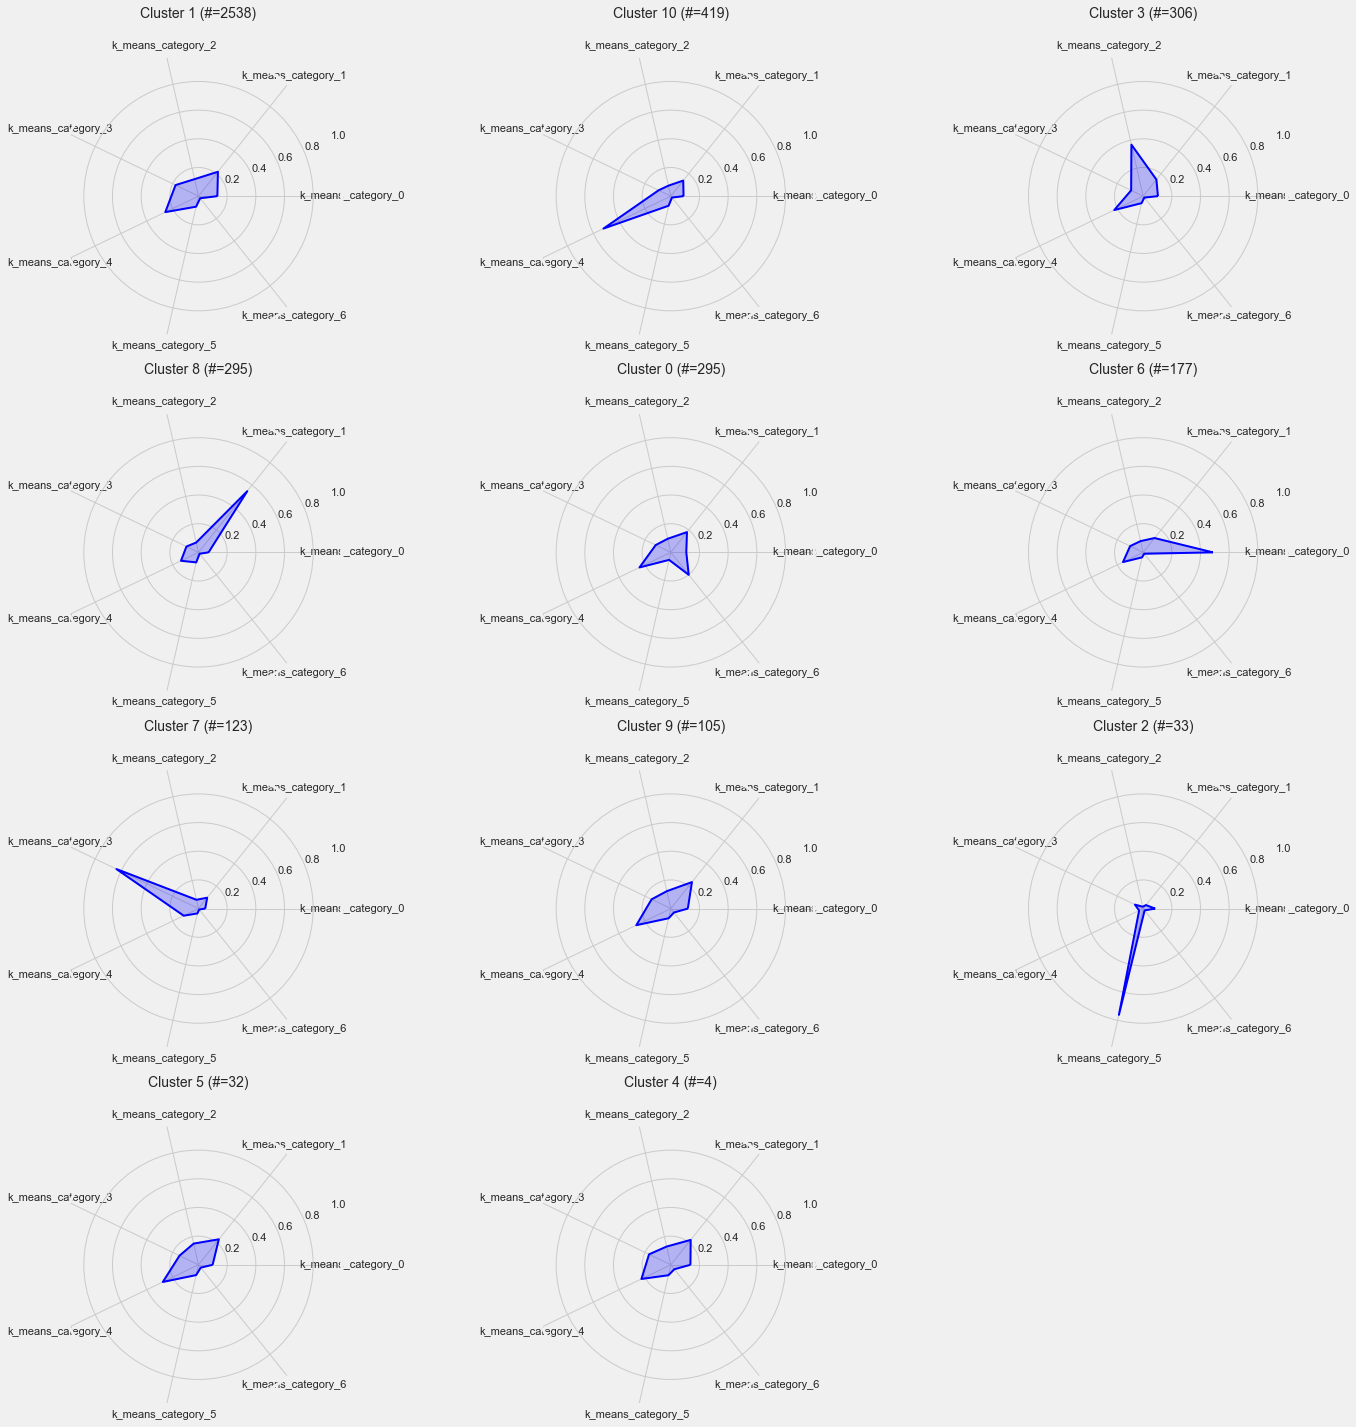

In [201]:
# Subplot parameters
categories = [f"k_means_category_{i}" for i in range(7)]
plot_radar_chart(categories)

- KMODES product categorical weight for each group

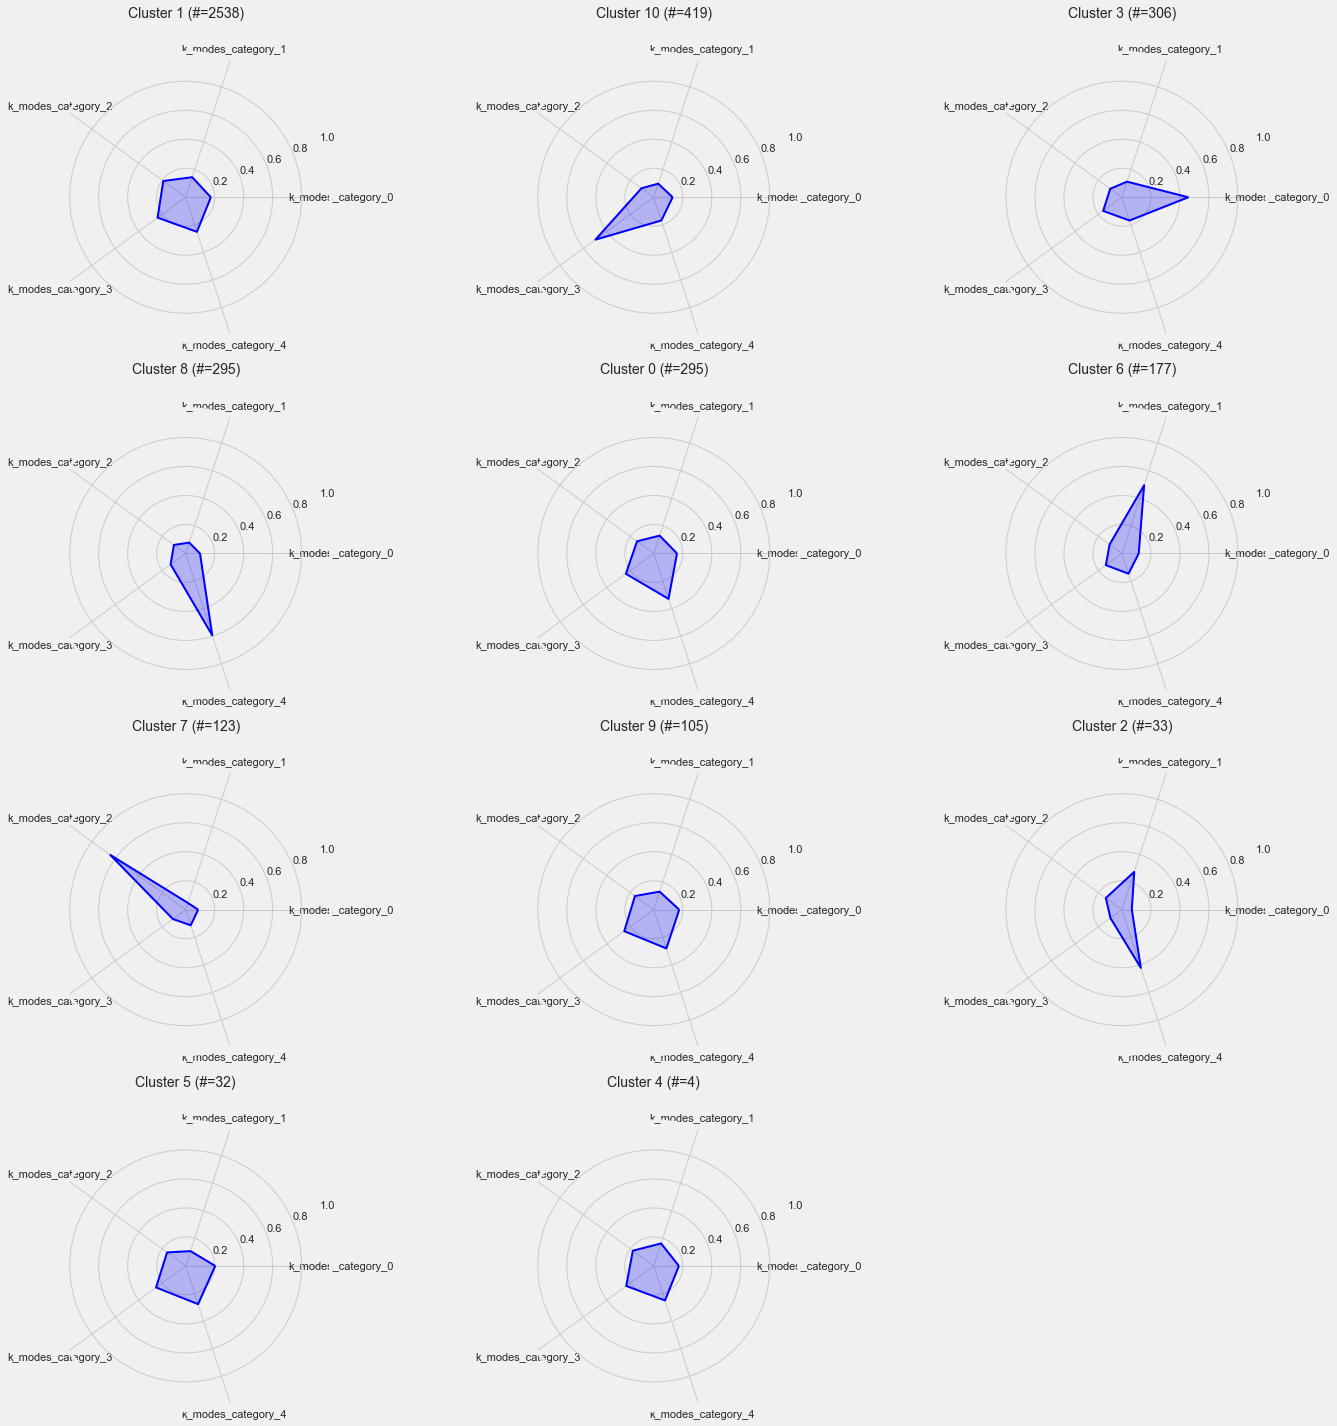

In [202]:
# Subplot parameters
categories = [f"k_modes_category_{i}" for i in range(5)]
plot_radar_chart(categories)

In [203]:
def round_to_sig_fig(value):
    if value == 0:
        return 0
    magnitude = 10 ** int(np.floor(np.log10(value)))
    return np.ceil(value / magnitude) * magnitude

def plot_radar_chart2(categories):
    # Subplot parameters
    num_clusters = len(customer_cluster)
    cols = 3
    rows = (num_clusters + cols - 1) // cols  # Calculate the number of rows needed

    # Create subplots
    fig, axs = plt.subplots(rows, cols, figsize=(20, rows * 5), subplot_kw=dict(polar=True))
    axs = axs.flatten()  # Flatten to 1D for easier indexing

    for i, row in enumerate(customer_cluster.iter_rows(named=True)):
        cluster_id = row["cluster"]
        cluster_num = customer_cluster_num.loc[cluster_id].values[0]
        values = [row[cat] for cat in categories]  # Exclude the 'cluster' column
        values += values[:1]  # Close the radar chart loop
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]

        # Dynamic y-axis ticks
        max_value = round_to_sig_fig(max(values))
        min_value = 0  # Radar charts typically start from 0
        num_ticks = 5  # Number of ticks on the y-axis
        tick_values = np.linspace(min_value, max_value, num_ticks + 1)

        # Plot radar chart for the current cluster
        ax = axs[i]
        ax.fill(angles, values, color="blue", alpha=0.25)
        ax.plot(angles, values, color="blue", linewidth=2)

        # Set dynamic scales
        ax.set_yticks(tick_values[:-1])  # Exclude the max_value as it's represented by the edge of the chart
        ax.set_yticklabels([f"{tick:.1e}" for tick in tick_values[:-1]], fontsize=10)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=10)
        ax.set_title(f"Cluster {cluster_id} (#={cluster_num})", fontsize=14, y=1.1)

    # Turn off unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


- KMEANS product categorical total sales for each group

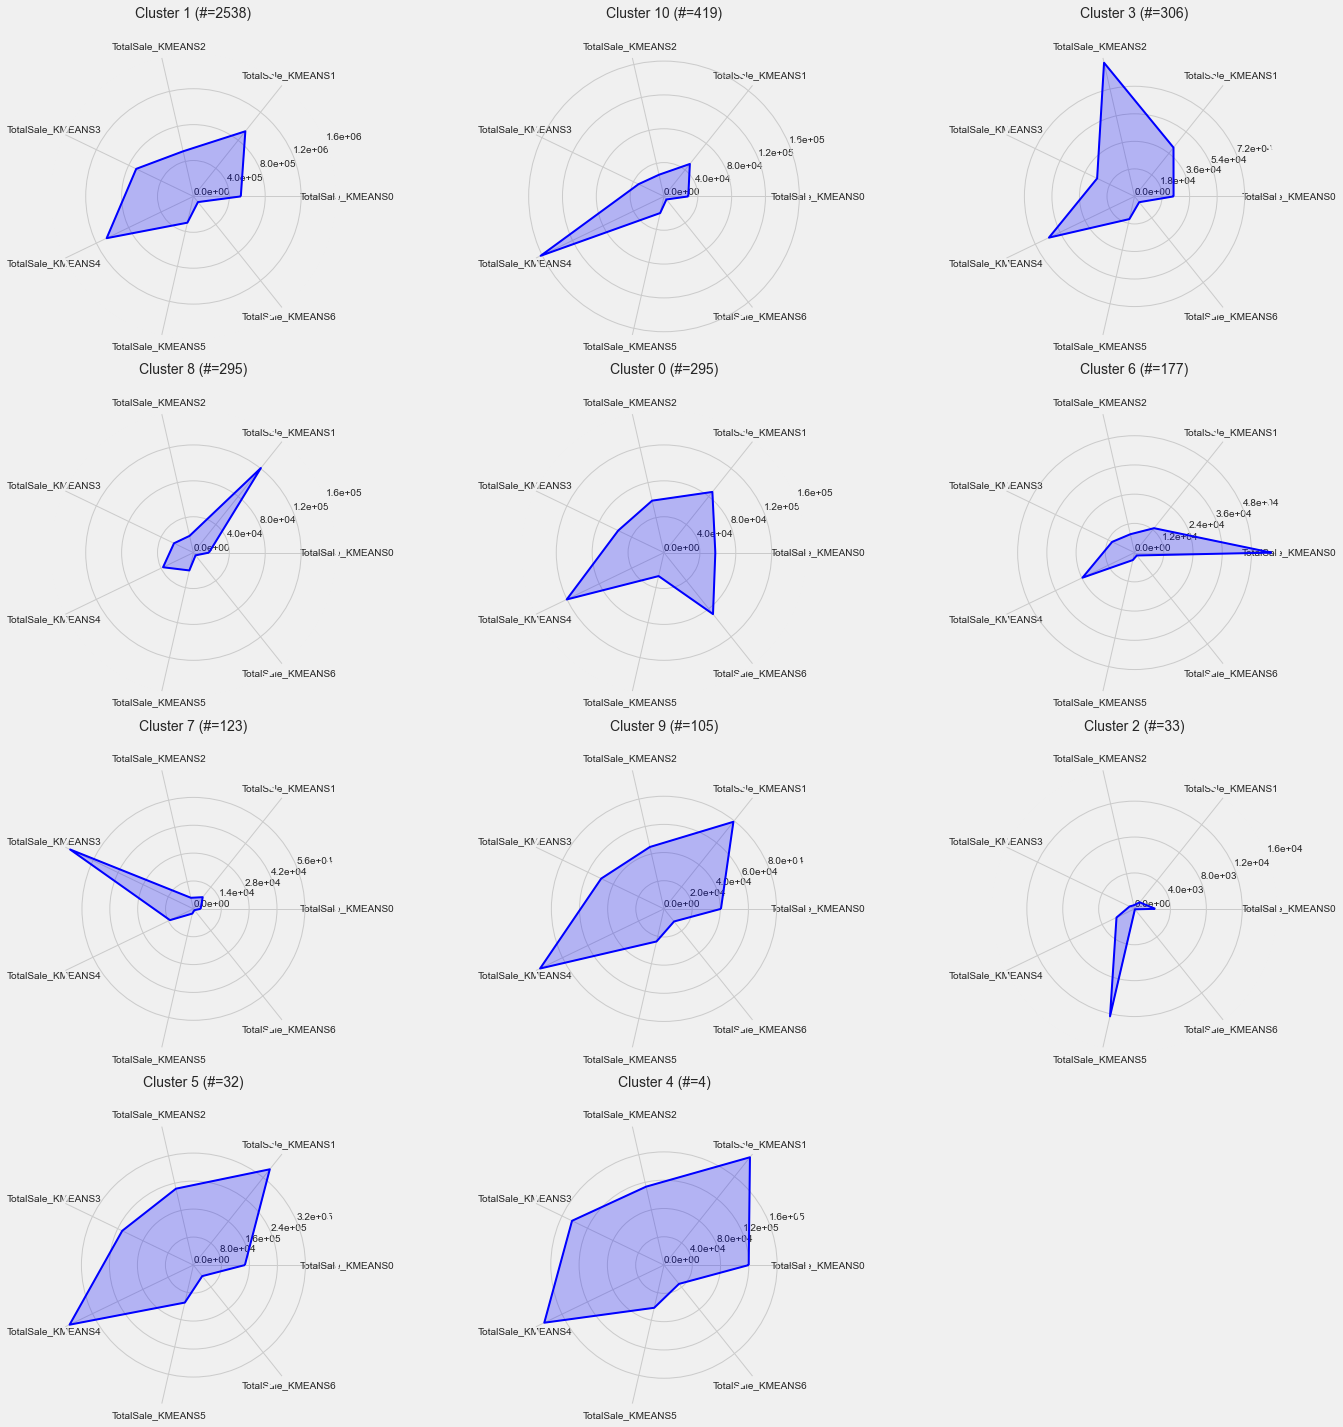

In [204]:
categories = [f"TotalSale_KMEANS{i}" for i in range(7)]
plot_radar_chart2(categories)

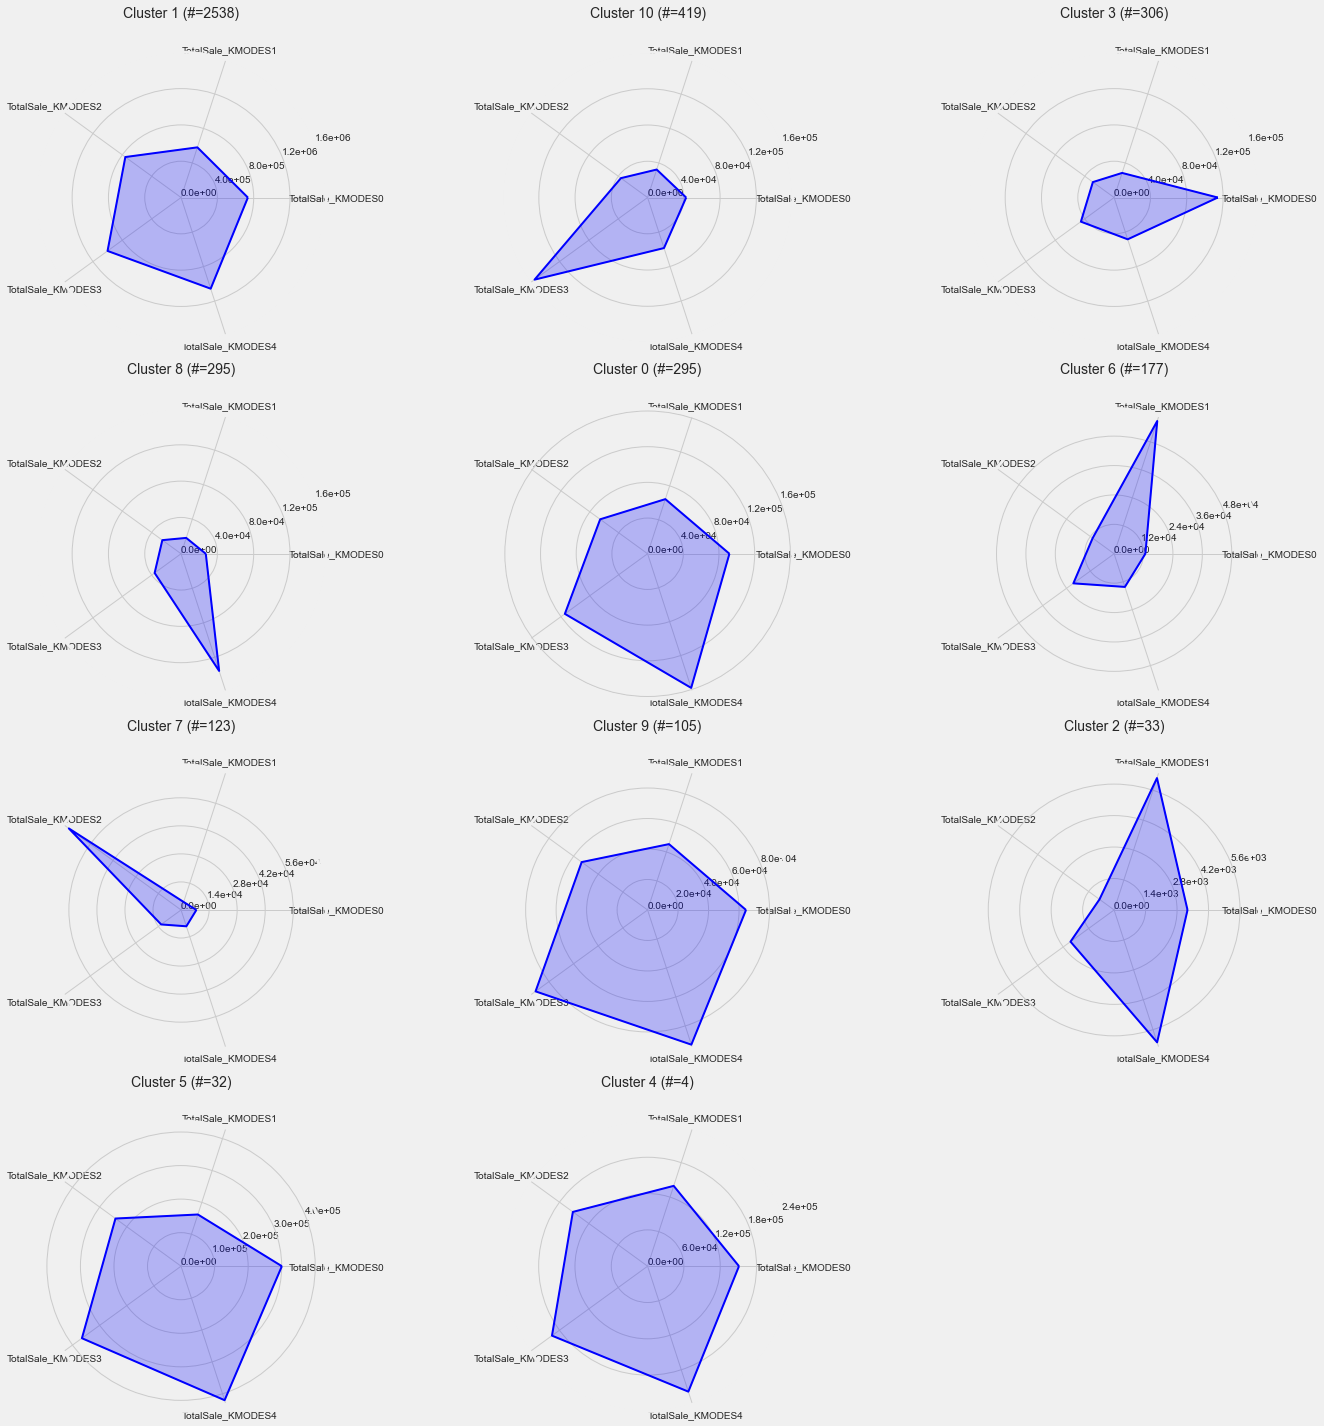

In [205]:
categories = [f"TotalSale_KMODES{i}" for i in range(5)]
plot_radar_chart2(categories)

Using radar plots, I was able to identify that **Product Category 1** and **Product Category 4** play a significant role in the segmentation derived from the K-Means clustering. These categories stand out because **Cluster 1**, which contributes the most to total sales, shows the highest weight on these two product categories.

This insight highlights the importance of these product categories in driving overall revenue, especially given the dominance of **Cluster 1** in sales contribution. Understanding this relationship provides actionable knowledge for strategic decision-making. For example:

1. **Marketing Focus**:  
   Efforts can be concentrated on promoting **Product Category 1** and **Product Category 4** to strengthen the purchasing habits of customers in **Cluster 1**.

2. **Inventory Management**:  
   Ensuring adequate stock levels for these categories can help meet customer demand and sustain sales performance.

3. **Customer Engagement**:  
   Tailored marketing strategies can be designed to engage customers in **Cluster 1**, such as exclusive deals or personalized recommendations focusing on these product categories.

Radar plots thus offer a visual way to grasp the relative importance of product categories within clusters, providing key insights for optimizing business strategies.


## 5. RFM Segment Analysis

In the previous section, I grouped customers into clusters based on the categories of products they purchased. In this section, I shift the focus to **RFM Analysis**, a widely used customer segmentation technique that evaluates customer behavior based on three key metrics:

1. **Recency (R)**: The time elapsed since the customer's last purchase.
2. **Frequency (F)**: The total number of purchases made by the customer.
3. **Monetary Value (M)**: The total amount spent by the customer.

### Approach:
- First, I calculate the **Recency**, **Frequency**, and **Monetary Value** for each customer using the transaction data.
- Based on these calculated values, I segment customers into distinct groups using RFM scoring or thresholds. Each customer is assigned a score for each metric, and the combination of these scores determines their segment.

### Purpose:
The goal of this analysis is to identify specific customer segments based on their purchasing behavior. RFM segmentation helps classify customers into meaningful groups such as:
- **Champions**: Recently active customers with high purchase frequency and spending.
- **Potential Loyalists**: Customers with recent activity but slightly lower frequency or spending.
- **About-to-Sleep**: Customers with declining engagement.
- **At Risk**: Customers who have not purchased in a long time.
- **Hibernating**: Customers who are least active or have churned.

### Benefits:
- **Personalized Marketing**: Enables targeted campaigns tailored to the needs and behaviors of each segment.
- **Retention Strategies**: Identifies segments requiring re-engagement, such as "At Risk" or "About-to-Sleep" customers.
- **Resource Allocation**: Helps prioritize efforts toward high-value customers like "Champions" and "Potential Loyalists."

### Summary:
By combining RFM analysis with the previous product-category-based clustering, I gain a deeper understanding of customer behavior. This dual segmentation approach allows for more precise targeting and strategy development to improve retention, loyalty, and overall customer satisfaction.


RFM SCORES

In [206]:
today_date = datetime.datetime(2011,12,11)
rfm = orders.group_by("CustomerID").agg(
    [
        pl.col("TotalSale").sum().alias("TotalSaleCustomer"),
        (pl.lit(today_date).cast(pl.Datetime) - pl.col("InvoiceDate").max())
        .cast(pl.Duration).alias("Recency"),
        pl.col("InvoiceNo").n_unique().alias("Frequency"),
        pl.col("TotalSale").sum().alias("Monetary"),
    ]
)
rfm = rfm.filter(pl.col("Monetary")>0)
rfm.head()

shape: (5, 5)
┌────────────┬───────────────────┬──────────────┬───────────┬──────────┐
│ CustomerID ┆ TotalSaleCustomer ┆ Recency      ┆ Frequency ┆ Monetary │
│ ---        ┆ ---               ┆ ---          ┆ ---       ┆ ---      │
│ i64        ┆ f64               ┆ duration[μs] ┆ u32       ┆ f64      │
╞════════════╪═══════════════════╪══════════════╪═══════════╪══════════╡
│ 12347      ┆ 4310.0            ┆ 3d 8h 8m     ┆ 7         ┆ 4310.0   │
│ 12348      ┆ 1797.24           ┆ 76d 10h 47m  ┆ 4         ┆ 1797.24  │
│ 12349      ┆ 1757.55           ┆ 19d 14h 9m   ┆ 1         ┆ 1757.55  │
│ 12350      ┆ 334.4             ┆ 311d 7h 59m  ┆ 1         ┆ 334.4    │
│ 12352      ┆ 2385.71           ┆ 37d 9h 23m   ┆ 8         ┆ 2385.71  │
└────────────┴───────────────────┴──────────────┴───────────┴──────────┘

In [235]:
rfm = (rfm.with_columns(
            # Recency score: Quantile bins with labels ["5", "4", "3", "2", "1"]
            pl.col("Recency").qcut(5, labels=["5", "4", "3", "2", "1"]).alias("recency_score"),
            # Frequency score: Rank first, then quantile bins with labels ["1", "2", "3", "4", "5"]
            pl.col("Frequency").rank().qcut(5, labels=["1", "2", "3", "4", "5"]).alias("frequency_score"),
            # Monetary score: Quantile bins with labels ["1", "2", "3", "4", "5"]
            pl.col("Monetary").qcut(5, labels=["1", "2", "3", "4", "5"]).alias("monetary_score"),    
        ).with_columns(
            # Combine scores into RFM_SCORE
            (pl.col("recency_score").cast(pl.String) + pl.col("frequency_score").cast(pl.String)).alias("RFM_SCORE")
        ))
rfm.head()

shape: (5, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ CustomerI ┆ TotalSale ┆ Recency   ┆ Frequency ┆ … ┆ frequency ┆ monetary_ ┆ RFM_SCORE ┆ segment  │
│ D         ┆ Customer  ┆ ---       ┆ ---       ┆   ┆ _score    ┆ score     ┆ ---       ┆ ---      │
│ ---       ┆ ---       ┆ duration[ ┆ u32       ┆   ┆ ---       ┆ ---       ┆ str       ┆ str      │
│ i64       ┆ f64       ┆ ns]       ┆           ┆   ┆ cat       ┆ cat       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 12347     ┆ 4310.0    ┆ 3d 8h 8m  ┆ 7         ┆ … ┆ 5         ┆ 5         ┆ 55        ┆ champion │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ s        │
│ 12348     ┆ 1797.24   ┆ 76d 10h   ┆ 4         ┆ … ┆ 4         ┆ 4         ┆ 24        ┆ at_Risk  │
│           ┆           ┆ 47m       ┆           ┆   ┆           ┆           ┆           ┆          │
│ 12349     ┆ 1757.55   ┆ 19d 14h   ┆ 1         ┆ … ┆ 1         ┆ 4         ┆ 41        ┆ promisin │
│           ┆           ┆ 9m        ┆           ┆   ┆           ┆           ┆           ┆ g        │
│ 12350     ┆ 334.4     ┆ 311d 7h   ┆ 1         ┆ … ┆ 1         ┆ 2         ┆ 11        ┆ hibernat │
│           ┆           ┆ 59m       ┆           ┆   ┆           ┆           ┆           ┆ ing      │
│ 12352     ┆ 2385.71   ┆ 37d 9h    ┆ 8         ┆ … ┆ 5         ┆ 5         ┆ 35        ┆ loyal_cu │
│           ┆           ┆ 23m       ┆           ┆   ┆           ┆           ┆           ┆ stomers  │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

C:\Users\lamor\AppData\Local\Temp\ipykernel_32104\2909550321.py:1: DeprecationWarning:

`GroupBy.count` is deprecated. It has been renamed to `len`.



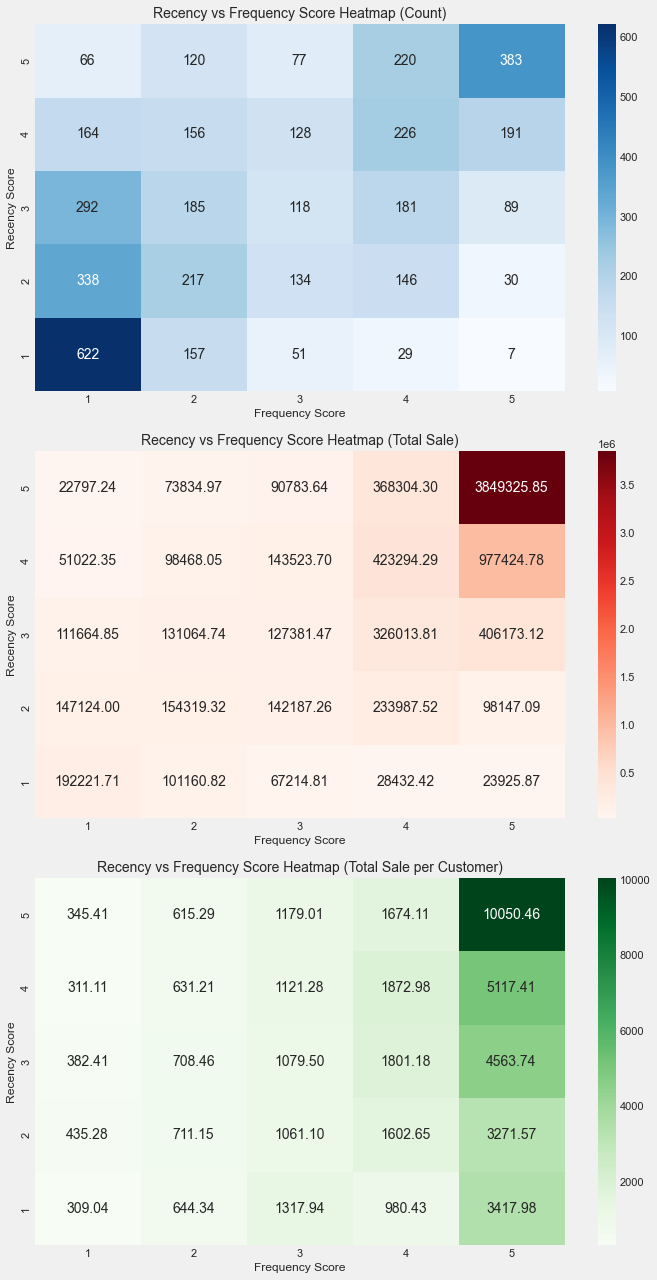

In [236]:
heatmap_matrix = rfm.group_by(["recency_score", "frequency_score"]).count().to_pandas()
heatmap_pivot = heatmap_matrix.pivot(
    index="recency_score", columns="frequency_score", values="count"
).fillna(0).astype(int)

sales_heatmap_matrix = (
    rfm.to_pandas().groupby(["recency_score", "frequency_score"])["Monetary"]
    .sum()
    .reset_index()
)

# Pivot the data for heatmap plotting
sales_heatmap_pivot = sales_heatmap_matrix.pivot(
    index="recency_score", columns="frequency_score", values="Monetary"
).fillna(0)

# Creating a 1x2 subplot for both heatmaps
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Plot the first heatmap (Count)
sns.heatmap(heatmap_pivot, annot=True, fmt="d", cmap="Blues", cbar=True, ax=axes[0])
axes[0].set_title("Recency vs Frequency Score Heatmap (Count)", fontsize=14)
axes[0].set_xlabel("Frequency Score", fontsize=12)
axes[0].set_ylabel("Recency Score", fontsize=12)

# Plot the second heatmap (Total Sale)
sns.heatmap(sales_heatmap_pivot, annot=True, fmt=".2f", cmap="Reds", cbar=True, ax=axes[1])
axes[1].set_title("Recency vs Frequency Score Heatmap (Total Sale)", fontsize=14)
axes[1].set_xlabel("Frequency Score", fontsize=12)
axes[1].set_ylabel("Recency Score", fontsize=12)

# Plot the third heatmap (Total Sale per Customer)
sales_per_customer_heatmap = sales_heatmap_pivot/heatmap_pivot
sns.heatmap(sales_per_customer_heatmap, annot=True, fmt=".2f", cmap="Greens", cbar=True, ax=axes[2])
axes[2].set_title("Recency vs Frequency Score Heatmap (Total Sale per Customer)", fontsize=14)
axes[2].set_xlabel("Frequency Score", fontsize=12)
axes[2].set_ylabel("Recency Score", fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

- customer segmentation map

In [237]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}
rfm = rfm.to_pandas()
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)
rfm = pl.DataFrame(rfm)
rfm.head()

shape: (5, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ CustomerI ┆ TotalSale ┆ Recency   ┆ Frequency ┆ … ┆ frequency ┆ monetary_ ┆ RFM_SCORE ┆ segment  │
│ D         ┆ Customer  ┆ ---       ┆ ---       ┆   ┆ _score    ┆ score     ┆ ---       ┆ ---      │
│ ---       ┆ ---       ┆ duration[ ┆ u32       ┆   ┆ ---       ┆ ---       ┆ str       ┆ str      │
│ i64       ┆ f64       ┆ ns]       ┆           ┆   ┆ cat       ┆ cat       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 12347     ┆ 4310.0    ┆ 3d 8h 8m  ┆ 7         ┆ … ┆ 5         ┆ 5         ┆ 55        ┆ champion │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ s        │
│ 12348     ┆ 1797.24   ┆ 76d 10h   ┆ 4         ┆ … ┆ 4         ┆ 4         ┆ 24        ┆ at_Risk  │
│           ┆           ┆ 47m       ┆           ┆   ┆           ┆           ┆           ┆          │
│ 12349     ┆ 1757.55   ┆ 19d 14h   ┆ 1         ┆ … ┆ 1         ┆ 4         ┆ 41        ┆ promisin │
│           ┆           ┆ 9m        ┆           ┆   ┆           ┆           ┆           ┆ g        │
│ 12350     ┆ 334.4     ┆ 311d 7h   ┆ 1         ┆ … ┆ 1         ┆ 2         ┆ 11        ┆ hibernat │
│           ┆           ┆ 59m       ┆           ┆   ┆           ┆           ┆           ┆ ing      │
│ 12352     ┆ 2385.71   ┆ 37d 9h    ┆ 8         ┆ … ┆ 5         ┆ 5         ┆ 35        ┆ loyal_cu │
│           ┆           ┆ 23m       ┆           ┆   ┆           ┆           ┆           ┆ stomers  │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

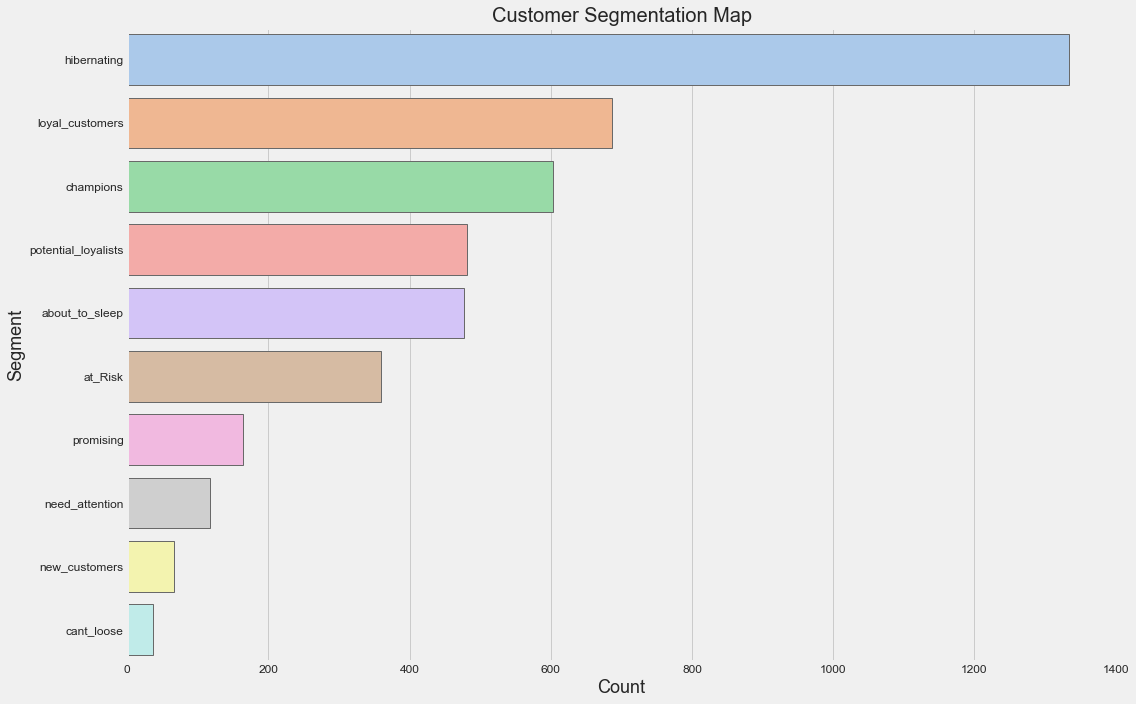

In [210]:
segments  = rfm["segment"].value_counts().sort(by='count', descending=True).to_pandas()
# Plot a bar chart
plt.figure(figsize=(16, 10))
sns.barplot(
    x="count",
    y="segment",
    data=segments,
    palette="pastel",  # Choose a nice palette for colors
)

# Add titles and labels
plt.title("Customer Segmentation Map", fontsize=20)
plt.xlabel("Count", fontsize=18)
plt.ylabel("Segment", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

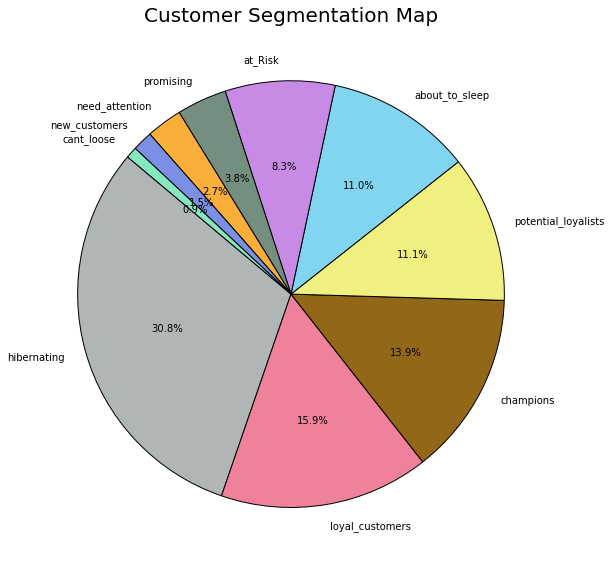

In [37]:
# Prepare data for pie chart
segments = rfm["segment"].value_counts().sort("count", descending=True).to_pandas()
labels = segments["segment"]
sizes = segments["count"]

# Plot a pie chart
plt.figure(figsize=(10, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',  # Display percentages
    colors=[
        "#AFB6B5", "#F0819A", "#926717", "#F0F081", "#81D5F0",
        "#C78BE5", "#748E80", "#FAAF3A", "#7B8FE4", "#86E8C0",
    ],
    startangle=140,
    wedgeprops={"edgecolor": "black", "linewidth": 1}
)
plt.title("Customer Segmentation Map", fontsize=20)
plt.tight_layout()
plt.show()

- Monetary and Frequency Stats Tables

In [38]:
rfm.to_pandas()[['Recency','Monetary','Frequency','segment']]\
.groupby('segment')\
.agg({'mean','std','max','min'})

C:\Users\lamor\AppData\Local\Temp\ipykernel_57636\1933844020.py:1: FutureWarning:

['Recency'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.



Monetary                                    Frequency  \
                           max         mean           std     min       max   
segment                                                                       
about_to_sleep         6207.67   508.867065    526.152656    6.20         2   
at_Risk               24850.90  1310.616697   1659.801535   70.02         6   
cant_loose            10232.88  3299.269189   2207.857836  752.32        34   
champions            279765.02  6994.411526  20567.629065  191.17       210   
hibernating            9861.38   445.896441    572.596185    3.75         2   
loyal_customers      123638.18  3104.666668   6162.410320   36.56        63   
need_attention         4821.00  1079.503983    824.396874   62.43         3   
new_customers          3861.00   345.412727    480.211576   41.99         1   
potential_loyalists   12393.70   845.343784    923.336456    2.90         3   
promising              2291.81   311.111890    298.566804   20.80         1   

                                               
                          mean        std min  
segment                                        
about_to_sleep        1.387841   0.487769   1  
at_Risk               3.766667   0.950590   3  
cant_loose           10.135135   4.916877   7  
champions            12.878939  16.747200   4  
hibernating           1.280360   0.449343   1  
loyal_customers       7.141194   4.678171   4  
need_attention        3.000000   0.000000   3  
new_customers         1.000000   0.000000   1  
potential_loyalists   2.426195   0.495038   2  
promising             1.000000   0.000000   1

- Customer Counts for each Segments

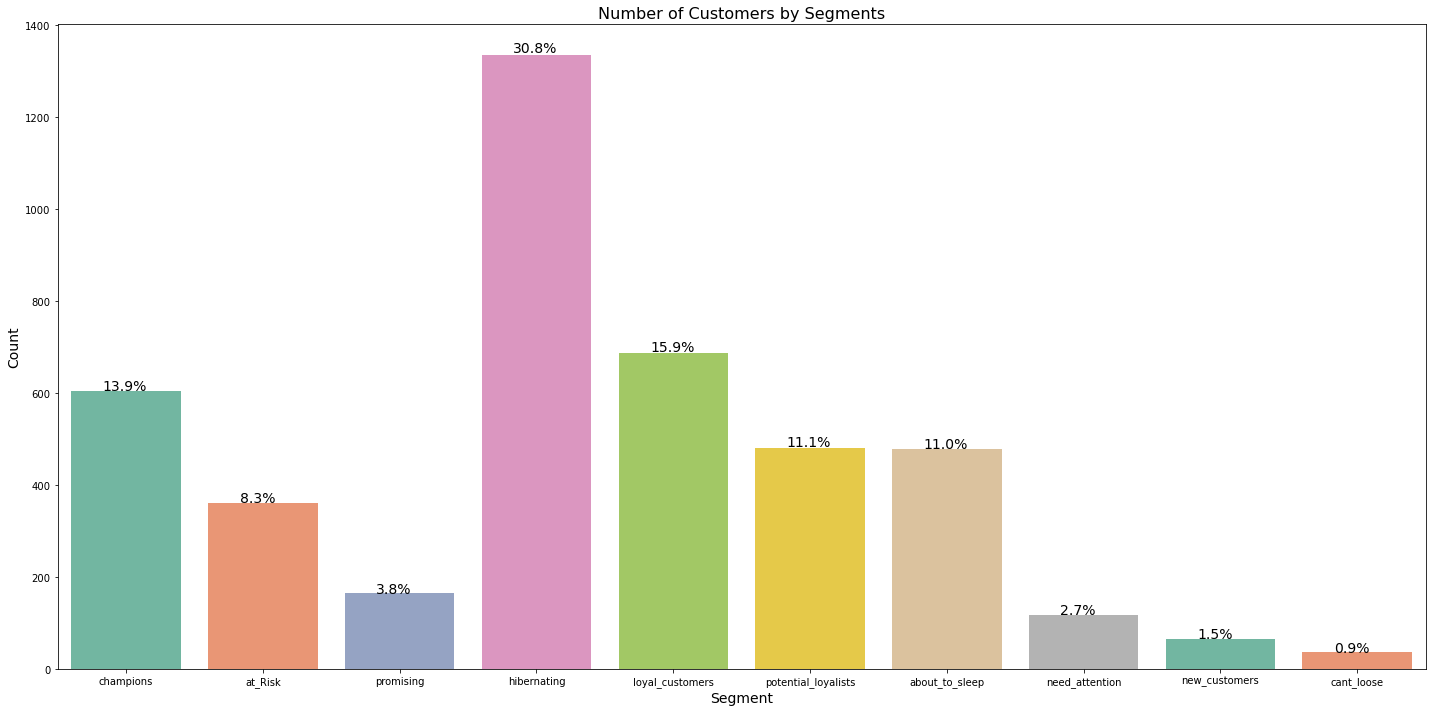

In [39]:
plt.figure(figsize = (20, 10))
ax = sns.countplot(data = rfm.to_pandas(),
                   x = 'segment',
                   palette = 'Set2')
total = len(rfm.to_pandas().segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
plt.title('Number of Customers by Segments', size = 16)
plt.xlabel('Segment', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.tight_layout()
plt.show()

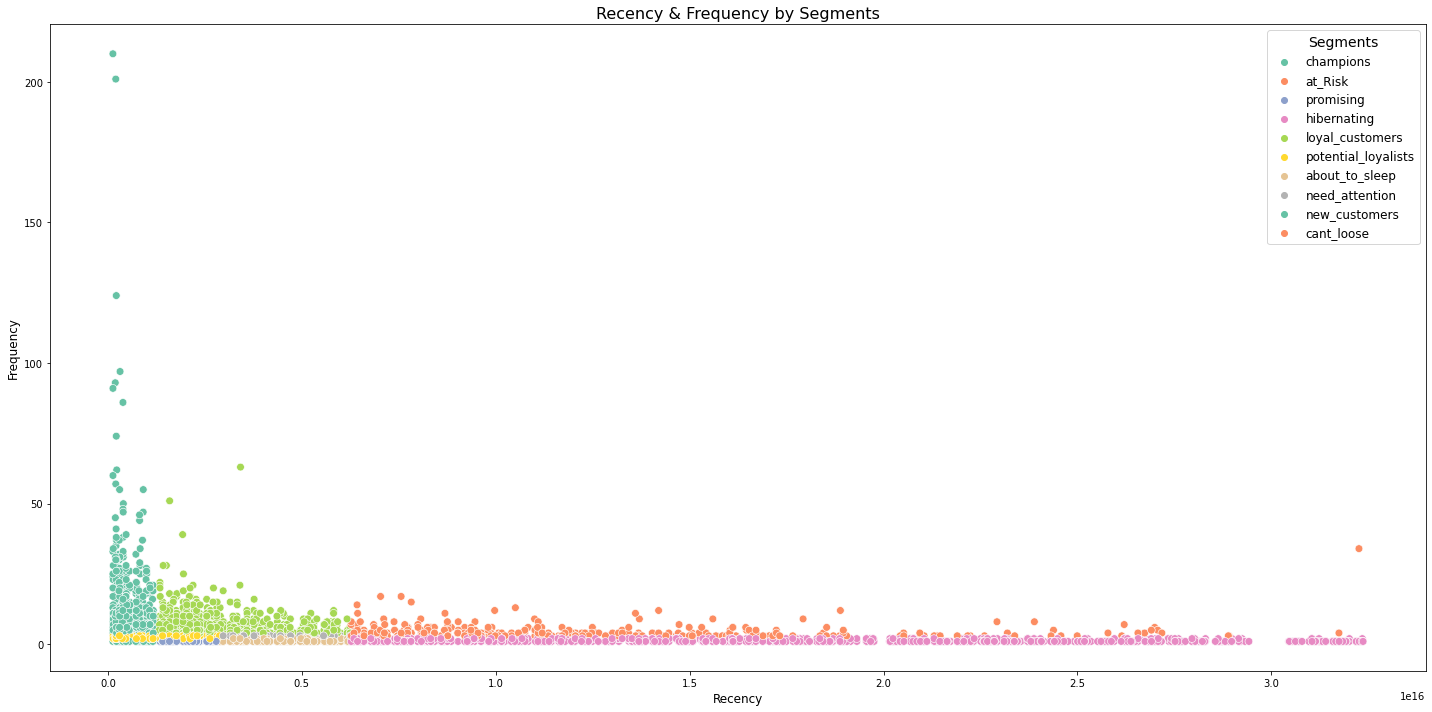

In [40]:
plt.figure(figsize=(20, 10))
sns.scatterplot(
    data=rfm.to_pandas(), x="Recency", y="Frequency", hue="segment", palette='Set2', s=60
)
plt.title("Recency & Frequency by Segments", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Frequency", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Segments", title_fontsize=14)
plt.tight_layout()
plt.show()

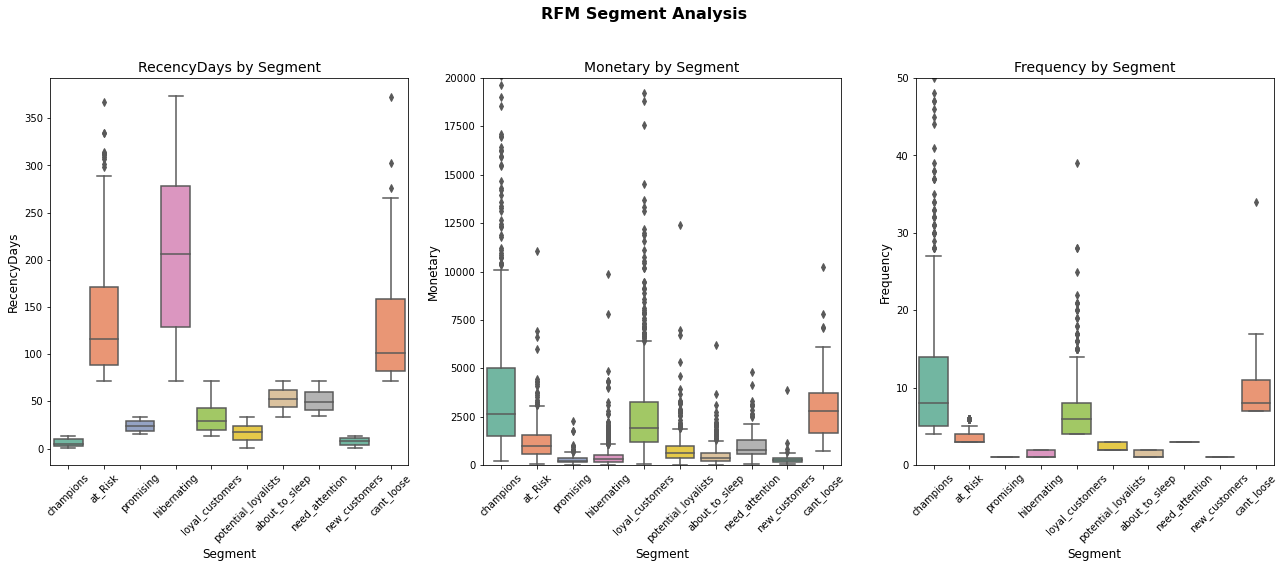

In [41]:
rfm_pd = rfm.to_pandas()
rfm_pd["RecencyDays"] = rfm_pd["Recency"].dt.days  # Convert timedelta to days
rfm_pd["RecencyDays"]

fig, axes = plt.subplots(1, 3, figsize=(18, 8))
fig.suptitle("RFM Segment Analysis", size=16, weight="bold")  # Adjusted title size and weight
feature_list = ["RecencyDays", "Frequency", "Monetary"] #

# Iterate over features and create boxplots
for idx, col in enumerate(feature_list):
    sns.boxplot(
        ax=axes[idx], 
        data=rfm_pd, 
        x="segment", 
        y=col, 
        palette="Set2"  # Color palette for better visualization
    )
    axes[idx].set_title(f"{col} by Segment", fontsize=14)  # Add individual titles
    axes[idx].set_xlabel("Segment", fontsize=12)
    axes[idx].set_ylabel(col, fontsize=12)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)  # Rotate x-axis labels

    # Set custom limits for specific plots
    if col == "Monetary":
        axes[idx].set_ylim([0, 20000])
    if col == "Frequency":
        axes[idx].set_ylim([0, 50])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()


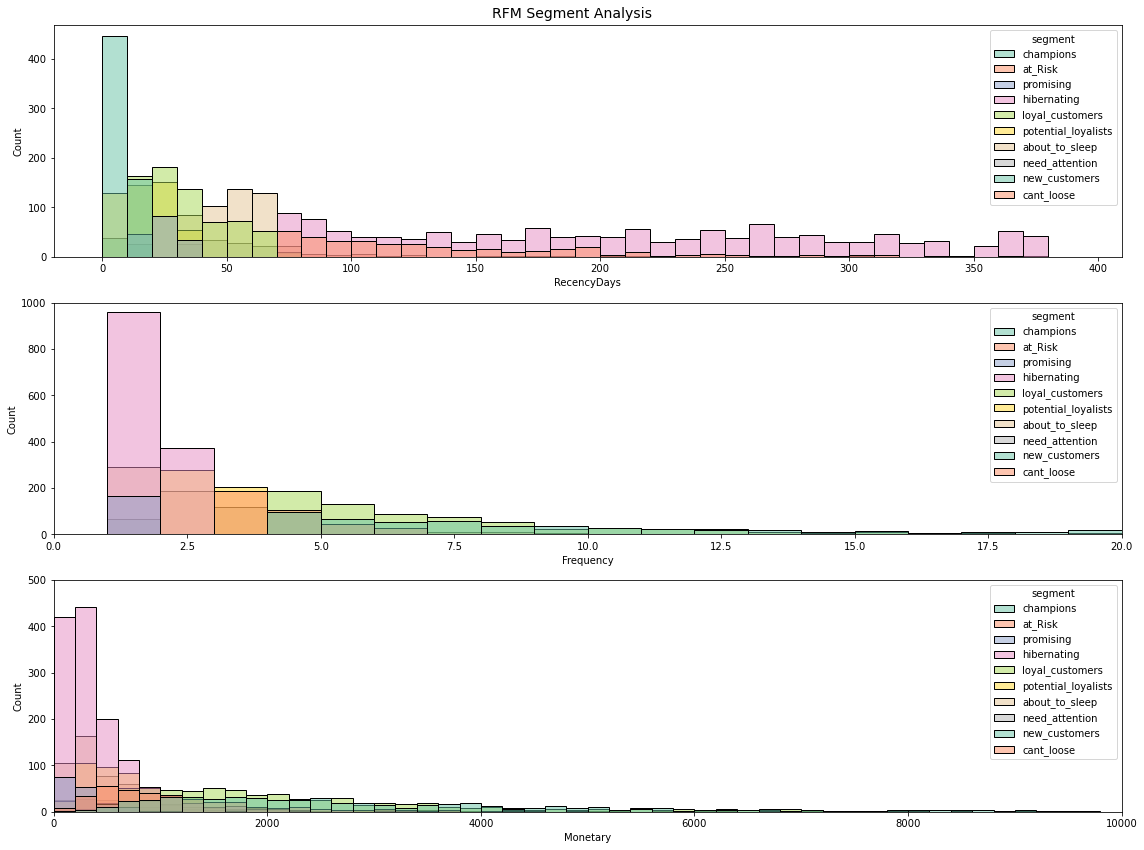

In [50]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('RFM Segment Analysis', size = 14)
feature_list = ["RecencyDays", "Frequency", "Monetary"] #
bins_list = [np.arange(0, 400, 10), np.arange(0, 21, 1), np.arange(0, 10000, 200)]  # Specify the number of bins for each subplot
for idx, (col, bins) in enumerate(zip(feature_list, bins_list)):
    sns.histplot(ax = axes[idx], 
                 data = rfm_pd,
                 hue = 'segment', 
                 x = feature_list[idx],
                 palette= 'Set2', bins=bins)
    # Set custom limits for specific plots
    if col == "Frequency":
        axes[idx].set_ylim([0, 1000])
        axes[idx].set_xlim([0, 20])
    if col == "Monetary":
        axes[idx].set_ylim([0, 500])
        axes[idx].set_xlim([0, 10000])
    
plt.tight_layout()
plt.show()

## 6. Cohort Analysis

In this section, I conduct a cohort analysis to examine customer retention trends over time. The dataset spans a 12-month period, making it ideal for dividing the data into monthly cohorts. Each cohort represents a group of customers who made their first purchase during a specific month. By tracking the behavior of these cohorts over subsequent months, I can visualize and analyze customer retention patterns.

### Explanation of the Cohort Retention Table:
- **Rows**: Each row corresponds to a cohort, defined by the month when customers made their first purchase.
- **Columns**: The columns represent the number of months since the cohort’s initial purchase (`# of periods`).
- **Values**: The percentages in each cell indicate the proportion of customers from a given cohort who made repeat purchases in that specific month.

### Insights:
1. **Cohort Size**: The first column shows the total number of customers in each cohort. Larger cohorts often reflect periods with higher acquisition efforts.
2. **Retention Trends**: Retention typically decreases over time, as expected. However, some months exhibit spikes in retention, possibly due to promotions or seasonal factors.
3. **Key Periods**: The first and second months are critical for retention, as the highest drop-off rates usually occur here. Interventions during these periods could improve overall retention rates.

This analysis provides a clear picture of customer retention dynamics, helping identify areas for improvement in customer engagement strategies and lifecycle management.

period_number   0         1         2         3         4         5   \
cohort                                                                 
2010-12        1.0  0.366102  0.323164  0.384181  0.362712  0.397740   
2011-01        1.0  0.220624  0.266187  0.230216  0.321343  0.287770   
2011-02        1.0  0.186842  0.186842  0.284211  0.271053  0.247368   
2011-03        1.0  0.150442  0.252212  0.199115  0.223451  0.168142   
2011-04        1.0  0.213333  0.203333  0.210000  0.196667  0.226667   
2011-05        1.0  0.190141  0.172535  0.172535  0.207746  0.232394   
2011-06        1.0  0.173554  0.157025  0.264463  0.231405  0.334711   
2011-07        1.0  0.180851  0.207447  0.223404  0.271277  0.111702   
2011-08        1.0  0.207101  0.248521  0.242604  0.124260       NaN   
2011-09        1.0  0.234114  0.301003  0.113712       NaN       NaN   
2011-10        1.0  0.240223  0.114525       NaN       NaN       NaN   
2011-11        1.0  0.111111       NaN       NaN       NaN       NaN   
2011-12        1.0       NaN       NaN       NaN       NaN       NaN   

period_number        6         7         8         9         10        11  \
cohort                                                                      
2010-12        0.362712  0.349153  0.353672  0.395480  0.374011  0.502825   
2011-01        0.247002  0.242206  0.299760  0.326139  0.364508  0.117506   
2011-02        0.252632  0.278947  0.247368  0.305263  0.068421       NaN   
2011-03        0.267699  0.230088  0.278761  0.086283       NaN       NaN   
2011-04        0.216667  0.260000  0.073333       NaN       NaN       NaN   
2011-05        0.264085  0.095070       NaN       NaN       NaN       NaN   
2011-06        0.095041       NaN       NaN       NaN       NaN       NaN   
2011-07             NaN       NaN       NaN       NaN       NaN       NaN   
2011-08             NaN       NaN       NaN       NaN       NaN       NaN   
2011-09             NaN       NaN       NaN       NaN       NaN       NaN   
2011-10             NaN       NaN       NaN       NaN       NaN       NaN   
2011-11             NaN       NaN       NaN       NaN       NaN       NaN   
2011-12             NaN       NaN       NaN       NaN       NaN       NaN   

period_number        12  
cohort                   
2010-12        0.265537  
2011-01             NaN  
2011-02             NaN  
2011-03             NaN  
2011-04             NaN  
2011-05             NaN  
2011-06             NaN  
2011-07             NaN  
2011-08             NaN  
2011-09             NaN  
2011-10             NaN  
2011-11             NaN  
2011-12             NaN

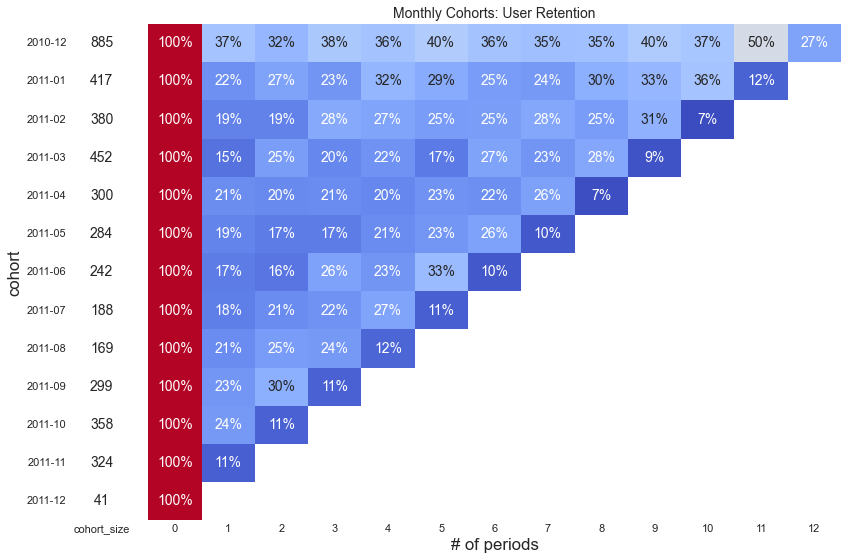

In [232]:
def CohortAnalysis(dataframe, cluster=None):
    data = dataframe.copy()
    data = data[["CustomerID", "InvoiceNo", "InvoiceDate"]].drop_duplicates()
    data["order_month"] = data["InvoiceDate"].dt.to_period("M")
    data["cohort"] = (
        data.groupby("CustomerID")["InvoiceDate"].transform("min").dt.to_period("M")
    )
    cohort_data = (
        data.groupby(["cohort", "order_month"])
        .agg(n_customers=("CustomerID", "nunique"))
        .reset_index(drop=False)
    )
    cohort_data["period_number"] = (cohort_data.order_month - cohort_data.cohort).apply(
        attrgetter("n")
    )
    cohort_pivot = cohort_data.pivot_table(
        index="cohort", columns="period_number", values="n_customers"
    )
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(
            1, 2, figsize=(12, 8), sharey=True, gridspec_kw={"width_ratios": [1, 11]}
        )
        sns.heatmap(
            retention_matrix,
            mask=retention_matrix.isnull(),
            annot=True,
            cbar=False,
            fmt=".0%",
            cmap="coolwarm",
            ax=ax[1],
        )
        if cluster is not None:
            ax[1].set_title(f"Monthly Cohorts: User Retention with cluster {cluster}", fontsize=14)
        else:
            ax[1].set_title("Monthly Cohorts: User Retention", fontsize=14)
        ax[1].set(xlabel="# of periods", ylabel="")
        white_cmap = mcolors.ListedColormap(["white"])
        sns.heatmap(
            pd.DataFrame(cohort_size).rename(columns={0: "cohort_size"}),
            annot=True,
            cbar=False,
            fmt="g",
            cmap=white_cmap,
            ax=ax[0],
        )
        fig.tight_layout()
    return retention_matrix
    
CohortAnalysis(orders.to_pandas())

In [240]:
customerClusterMap = {customerID: cluster for customerID, cluster in zip(customer['CustomerID'], customer['cluster'])}
customerClusterMapRFM = {customerID: cluster for customerID, cluster in zip(rfm['CustomerID'], rfm['segment'])}

orders = orders.with_columns(
    pl.col("CustomerID").map_elements(
        lambda x: customerClusterMap.get(x, -1), return_dtype=pl.Int8  # Use `.get()` to return -1 for missing keys
    ).alias("cluster"),
    pl.col("CustomerID").map_elements(
        lambda x: customerClusterMapRFM.get(x, -1), return_dtype=pl.String  # Use `.get()` to return -1 for missing keys
    ).alias("clusterRFM")
)

#### 6.1 Chohort Analysis with Customer Segmentation

In this section, I perform a cohort analysis for each customer cluster identified in Section 4. By combining cohort analysis with customer segmentation, I aim to uncover retention patterns and behavioral trends specific to each cluster.

##### Purpose:
The goal is to analyze how different customer groups (clusters) contribute to overall retention rates and whether certain segments exhibit stronger loyalty or engagement over time.

##### Approach:
1. **Segmentation-Based Cohorts**:  
   I divide the customers into their respective clusters (as determined in Section 4) and perform cohort analysis for each cluster separately. This involves tracking retention rates over time for each segment.
   
2. **Retention Insights per Cluster**:  
   By isolating cohorts by clusters, I can identify:
   - Which customer groups demonstrate the highest retention.
   - How retention behavior differs between high-value (e.g., Cluster 1) and lower-value customer groups.
   - Opportunities for tailoring engagement strategies to specific segments.


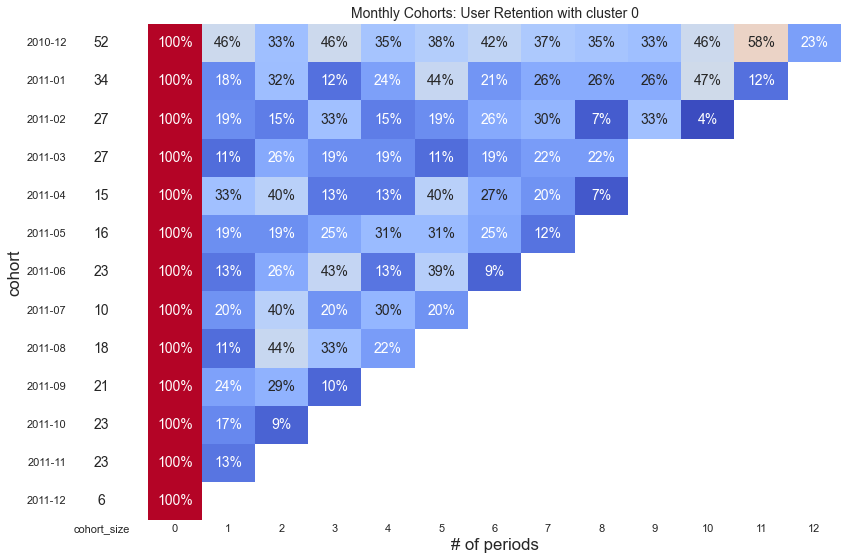

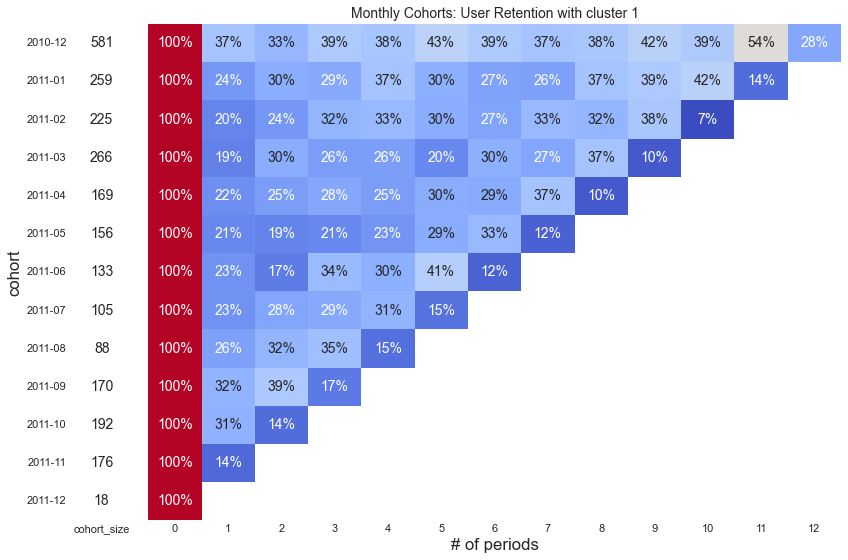

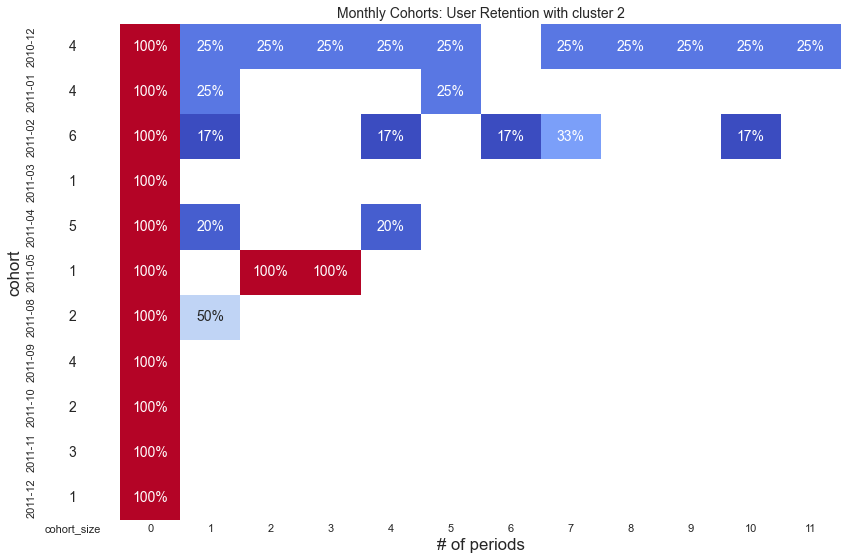

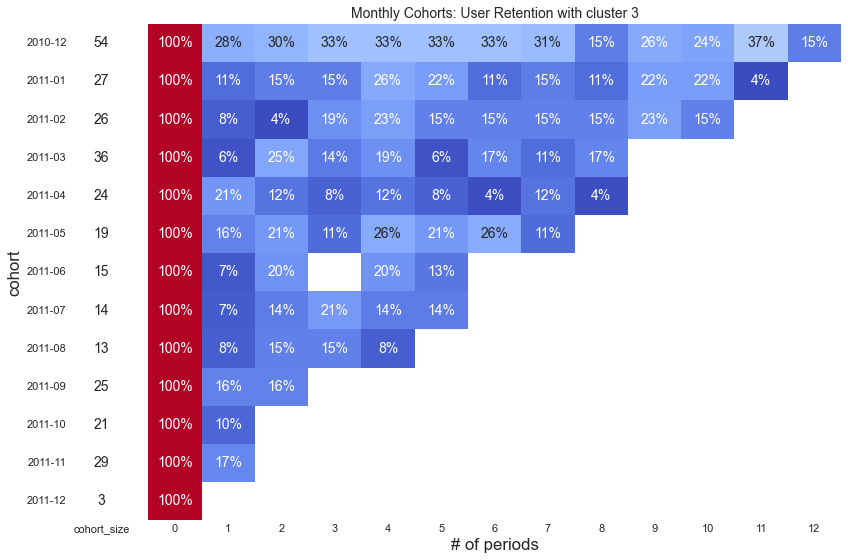

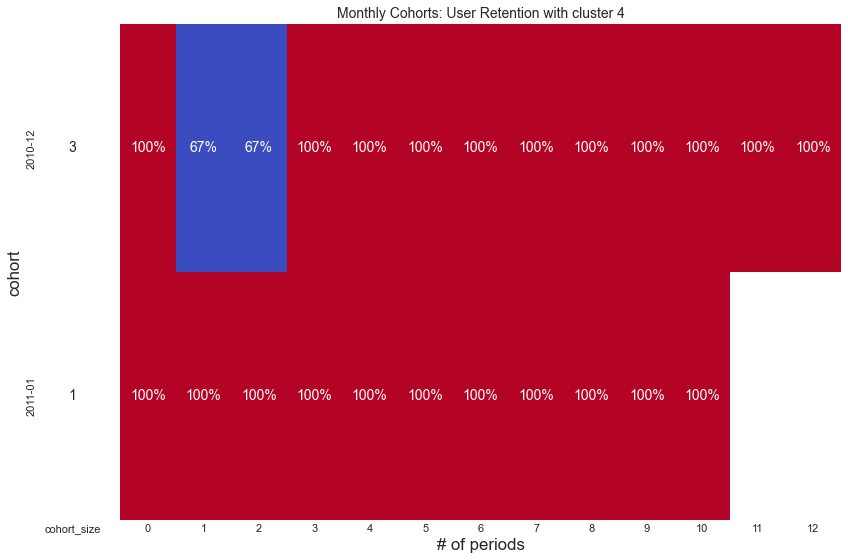

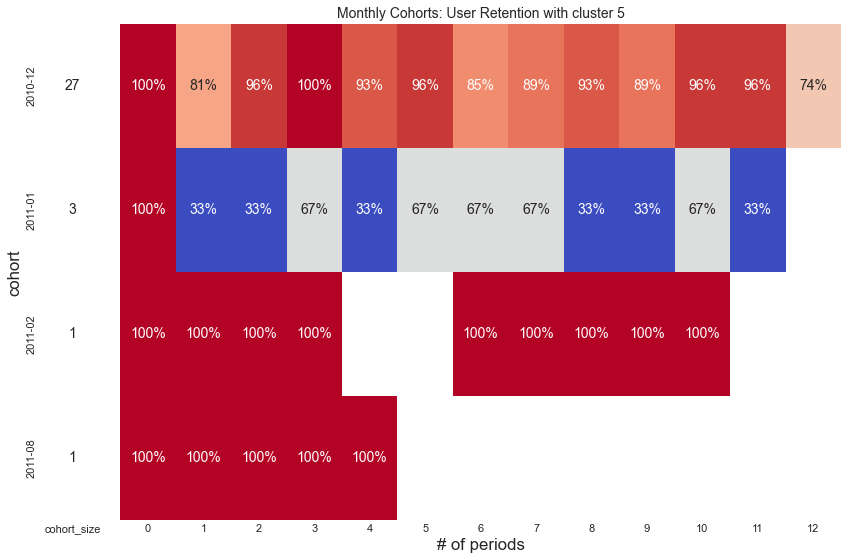

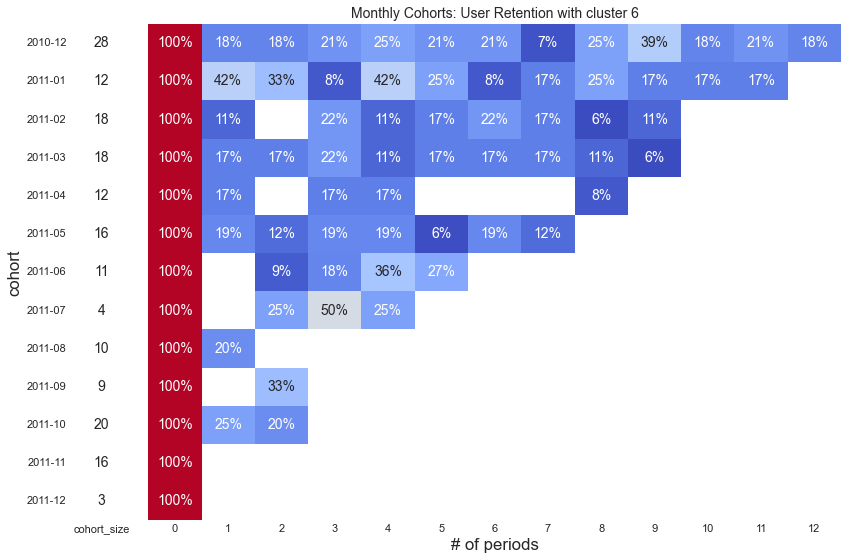

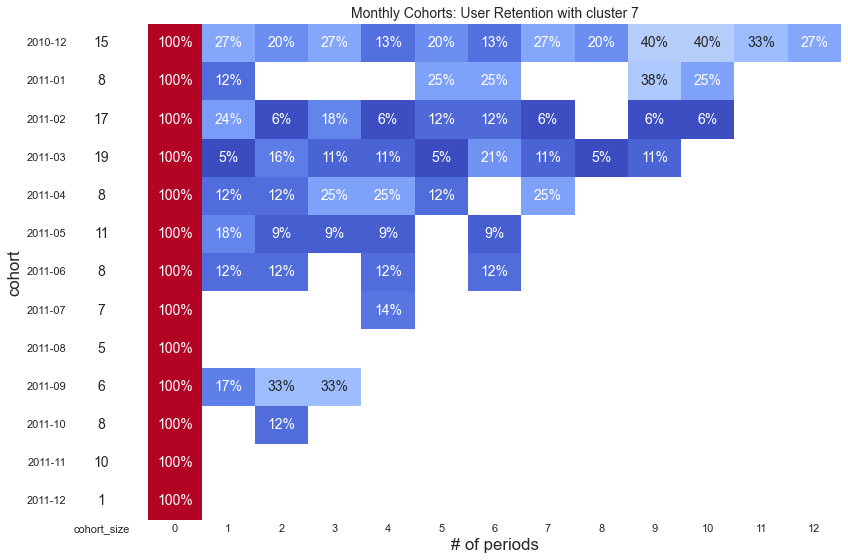

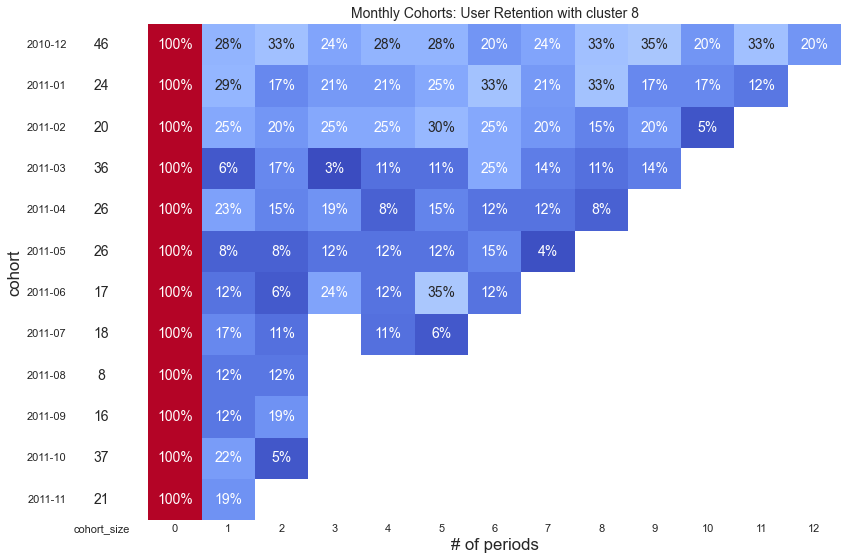

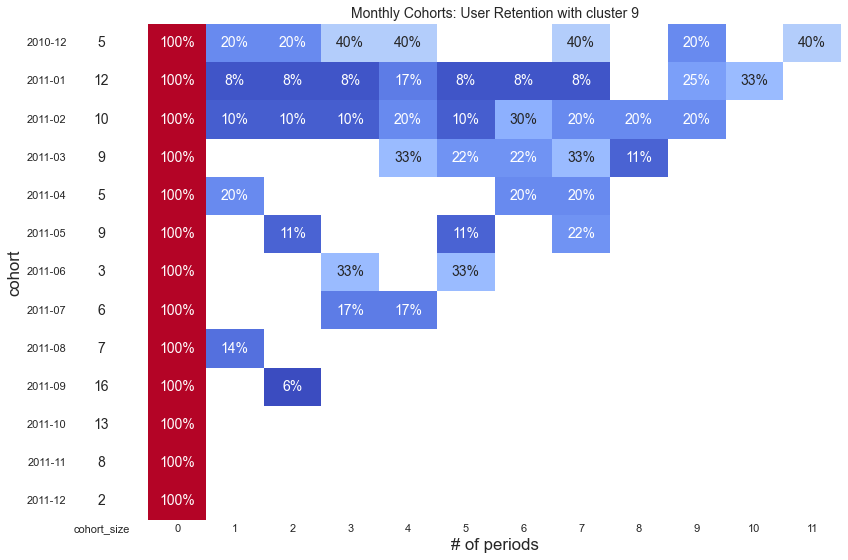

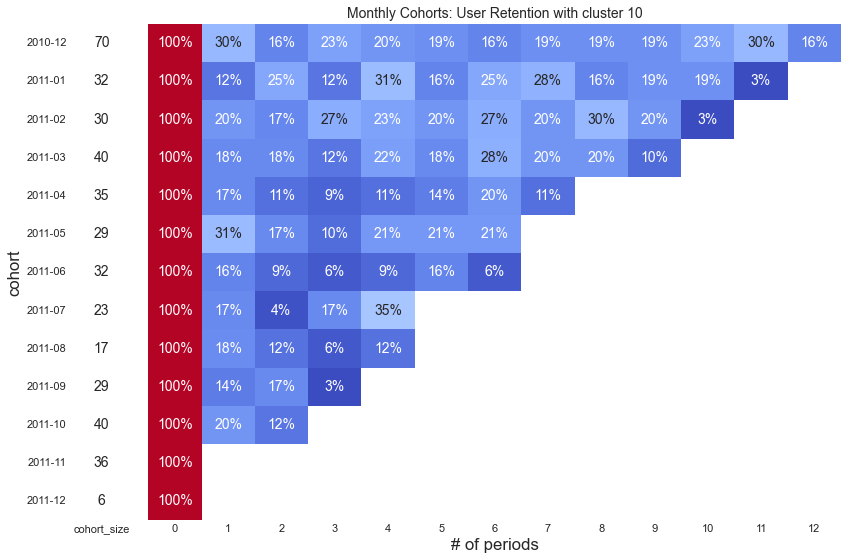

In [234]:
for i in range(11):
    CohortAnalysis(orders.filter(pl.col("cluster")==i).to_pandas(), cluster=i)

#### 6.2 Cohort Analysis with RFM Segmentation

In this section, I perform a cohort analysis for each customer segment identified through RFM (Recency, Frequency, Monetary) segmentation in Section 5. By combining RFM segmentation with cohort analysis, I aim to uncover retention patterns and behavioral trends specific to each segment.


This analysis allows me to explore how different customer segments retain over time and identify key behavioral patterns across these groups.

##### Observations:
1. **Differentiated Retention Patterns**:  
   The RFM segmentation revealed distinct retention behaviors among customer groups:
   - For example, **Potential Loyalists**, **Customers Needing Attention**, and **About-to-Sleep** segments showed a noticeable increase in retention last month. However, retention rates for these groups dropped again this month.

2. **Impact of Events**:  
   The significant retention increase last month could indicate the impact of specific events or promotions that encouraged repeat purchases. Even if the event occurred over a month ago, its effects appear to linger, as retention rates during the post-event period remain higher than before the event.

3. **Key Insights**:  
   - **Potential Loyalists**: Efforts to solidify loyalty in this group might yield long-term benefits.
   - **Customers Needing Attention**: This group may require targeted re-engagement strategies to prevent further drop-offs.
   - **About-to-Sleep**: Tailored campaigns might help reactivate these customers and stabilize retention.

##### Recommendations:
- Investigate the events or promotions that led to increased retention in the last month and consider replicating or refining these efforts.
- Develop targeted strategies for each RFM segment to address their specific needs and behaviors.
- Continuously monitor retention patterns to measure the long-term effectiveness of engagement efforts.

This combined analysis of cohort trends and RFM segmentation provides actionable insights for improving customer retention and fostering loyalty in key segments.

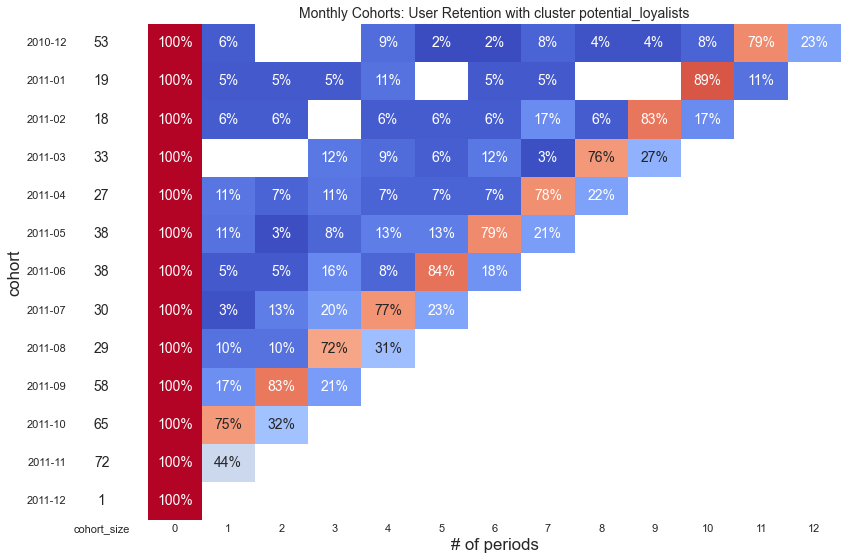

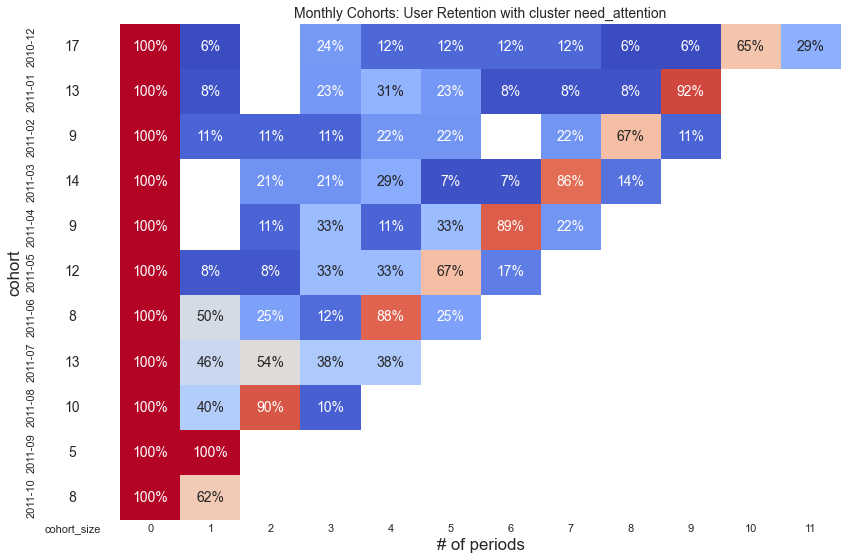

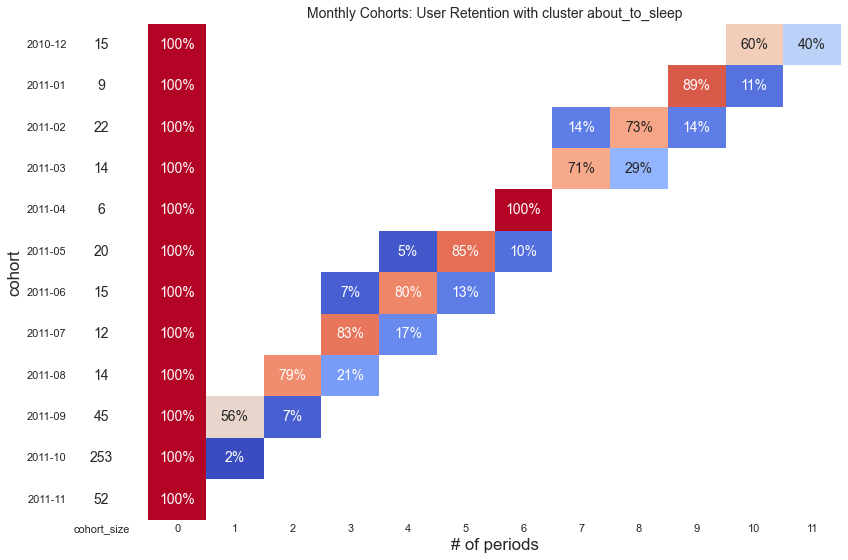

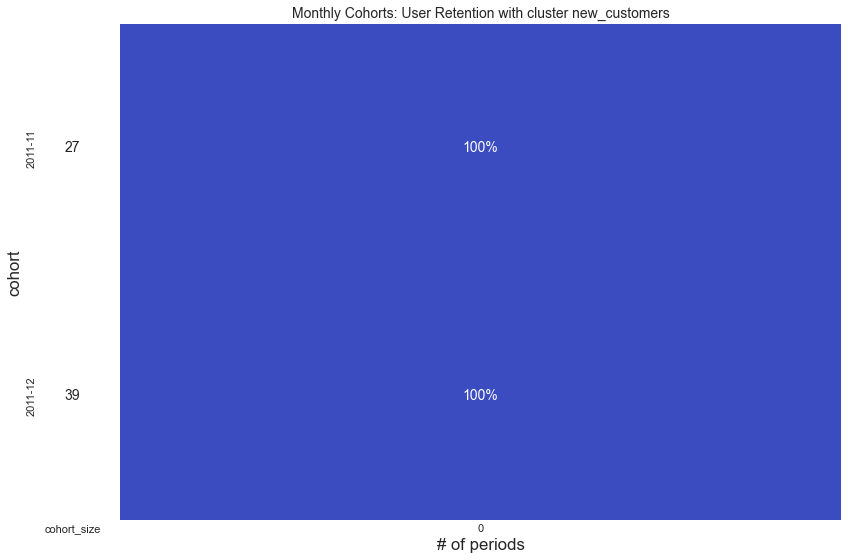

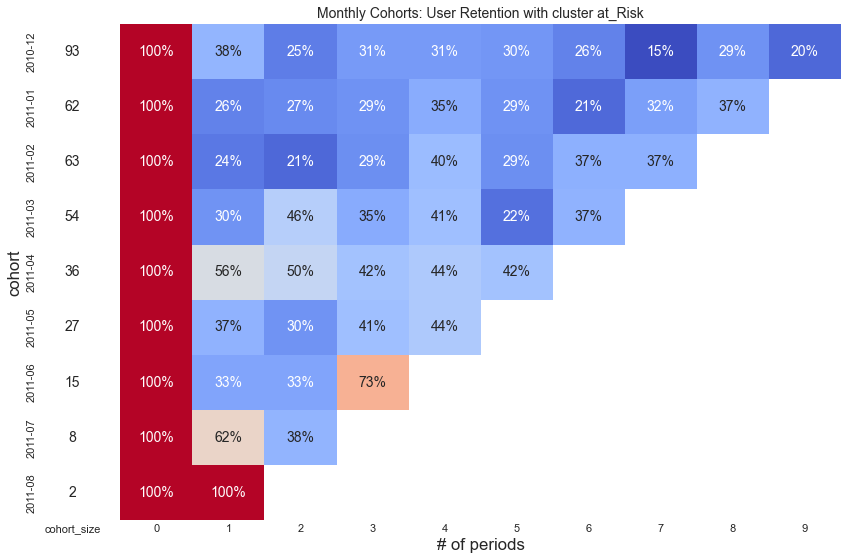

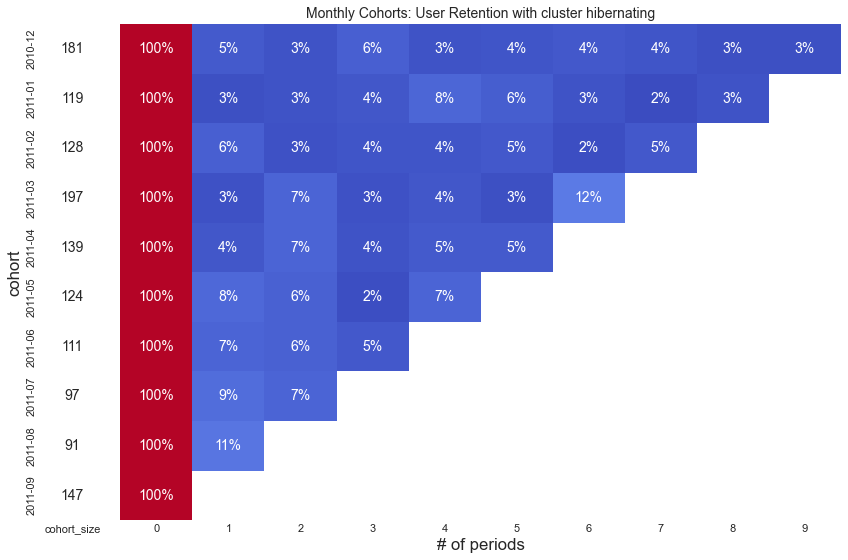

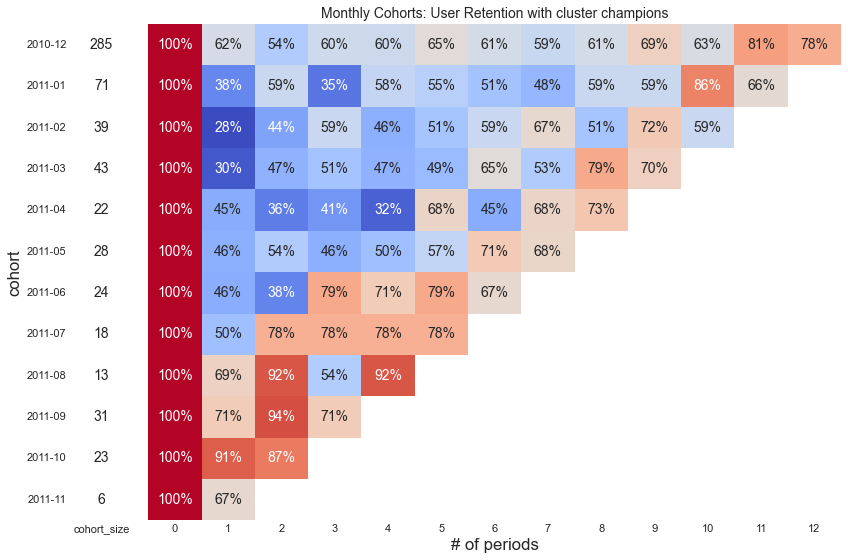

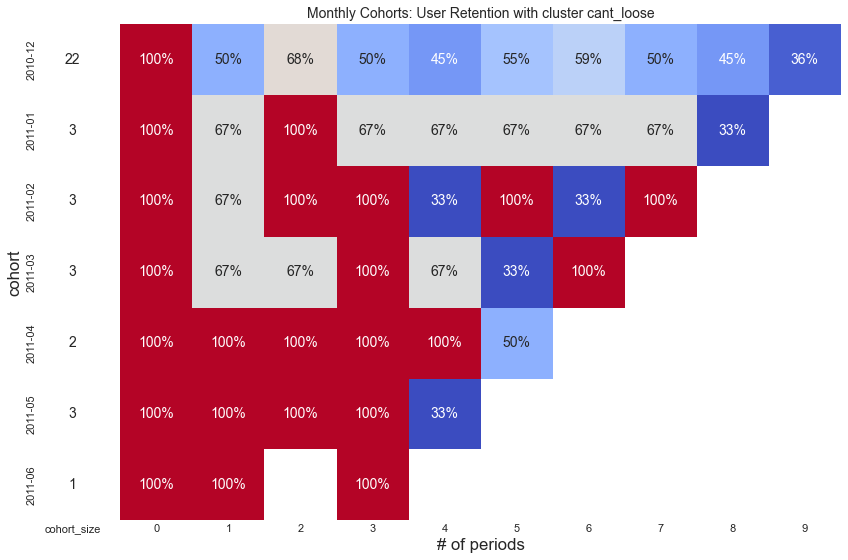

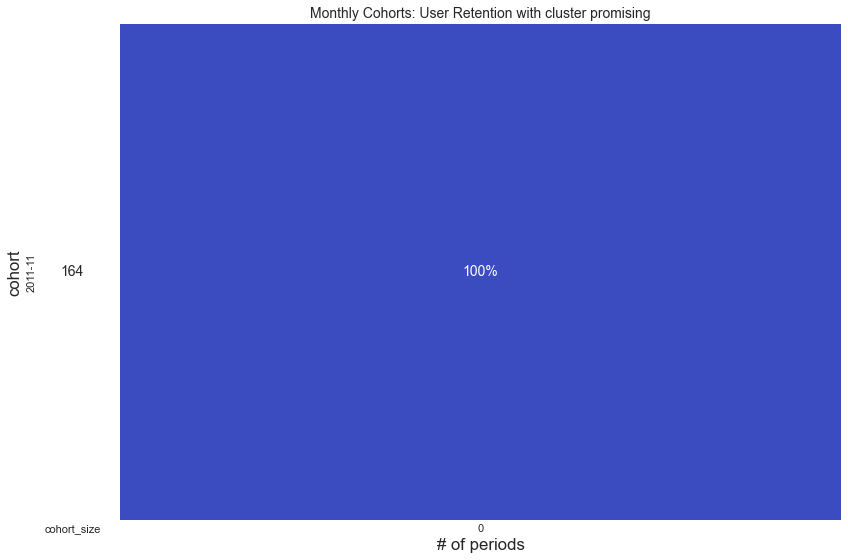

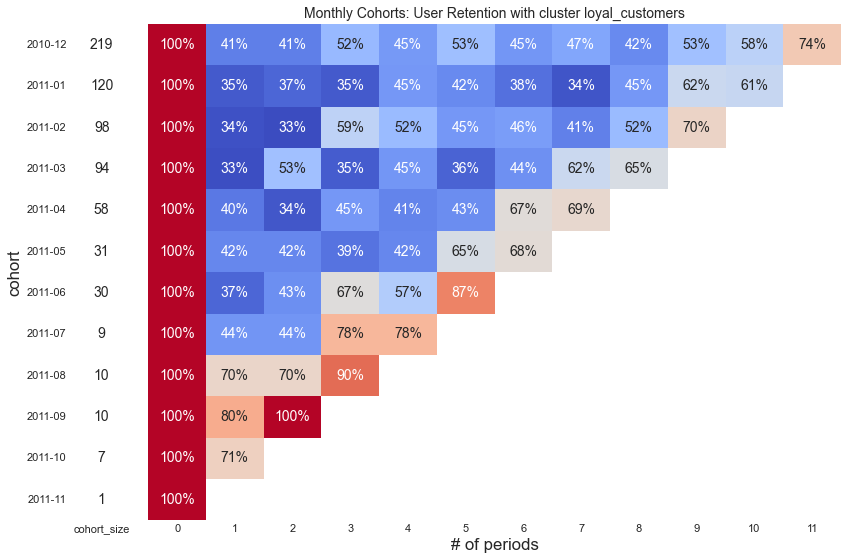

In [246]:
for rfm_seg in list(set(rfm['segment'])):
    CohortAnalysis(orders.filter(pl.col("clusterRFM")==rfm_seg).to_pandas(), cluster=rfm_seg)

## Conclusion

This project explored customer behavior and purchasing patterns using various analytical techniques, including segmentation, cohort analysis, and RFM analysis. By leveraging the insights gained, businesses can develop targeted strategies to enhance customer retention, improve loyalty, and boost overall sales performance.

### Key Takeaways:
1. **Customer Segmentation by Product Categories**:
   - Identified clusters of customers based on the categories of products they purchased.
   - Highlighted the importance of certain product categories, such as Category 1 and Category 4, which significantly contributed to the total sales in key customer segments.

2. **RFM Analysis**:
   - Segmented customers based on Recency, Frequency, and Monetary value.
   - Revealed critical customer groups such as "Champions," "Potential Loyalists," and "At Risk."
   - Provided actionable insights for targeted engagement strategies, such as reactivating dormant customers and rewarding loyal ones.

3. **Cohort Analysis**:
   - Analyzed retention trends over time and across customer segments.
   - Highlighted the impact of specific events or promotions on retention rates.
   - Provided a deeper understanding of how customer behavior evolves over time.

4. **Combining Segmentation with Cohort Analysis**:
   - Uncovered retention patterns specific to customer segments.
   - Demonstrated the value of tailoring strategies to individual groups, such as focusing on high-value customers or re-engaging at-risk groups.

### Recommendations:
- **Retention Strategies**: Focus on re-engaging at-risk and dormant customers through personalized marketing campaigns and exclusive offers.
- **Loyalty Programs**: Invest in loyalty programs to reward high-value customers, such as "Champions" and "Potential Loyalists," to sustain their engagement.
- **Promotional Campaigns**: Analyze the impact of successful events and replicate similar strategies to maintain or improve retention.
- **Product Focus**: Prioritize inventory management and promotional efforts for high-impact product categories, such as Category 1 and Category 4.

### Final Thoughts:
By combining advanced segmentation techniques with behavioral analyses, this project provides a solid foundation for data-driven decision-making. The insights gained can help businesses better understand their customers, optimize marketing efforts, and ultimately improve their overall profitability.
